# AOS DM-33104 : move mask away from donut

Use donuts from corner sensor simulation, taken via 


    cd /project/scichris/aos/masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/
    rsync -rtvPh suberlak@epyc.astro.washington.edu:/epyc/users/brycek/Commissioning/aos/aoclc_runs/closeLoopTests/cwfs_ps1_high_density_10_DM-34565/phosimData/  .



Stay as close to `Algorithm.py` as possible. 

Instead of moving the centroid information (which only moves the fieldXY), move the actual mask (try to evaluate it for a wrong location).

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams 

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
)
import os

from lsst.daf import butler as dafButler
from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import DefocalType, CamType, CentroidFindType
from scipy.ndimage import rotate




In [2]:
def get_butler_stamps(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     dataset_type = 'donutStampsExtra', collection=''):
    #repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}

    donutStamps = butler.get(dataset_type, 
                              dataId=dataId, 
                              collections=[collection])  
    
    donutCatalog = butler.get('donutCatalog', 
                              dataId=dataId, 
                              collections=[collection]) 
    return donutStamps, donutCatalog


def get_butler_image(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     collection=''):
    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    postIsr = butler.get('postISRCCD',dataId=dataId, 
                          collections=[collection])
    return postIsr



Instead of doing 

    repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'

    instrument = 'LSSTCam'
    collection = 'ts_phosim_9006070'

    # iterate over all sensors
    for sensor in ['R00','R40','R44','R04']: 
        print(f'Fitting {sensor}')
        extraFocalStamps, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                              iterN=0, detector=f"{sensor}_SW0",
                                              dataset_type = 'donutStampsExtra', 
                                              collection=collection)

        intraFocalStamps, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                              iterN=0, detector=f"{sensor}_SW1",
                                              dataset_type = 'donutStampsIntra', 
                                              collection=collection)



        zernConfig = EstimateZernikesCwfsTaskConfig(initialCutoutPadding=5)
        zernTask = EstimateZernikesCwfsTask(config=zernConfig)

        # fit all donuts
        zkRes = zernTask.estimateZernikes(intraFocalStamps, extraFocalStamps)

        # store the result
        #np.save(f'zkRes_{sensor}_DM-33178.npy',zkRes)
        np.save(f'zkRes_{sensor}_DM-33178_undo.npy',zkRes)

        #np.save(f'zkRes_{sensor}_develop.npy',zkRes)
        
I dig into `EstimateZernikesCwfsTask` and `wfEstimator` to get closer to `Algorithm.py` and explicitly see what happens at each stage. 

It happens that really most of the instrument-specific part of the `EstimateZernikesCwfsTask` is donut-cutting stage. Once we have the donut stamps, the steps are just calling `estimateZernikes` method which is inherited from `EstimateZernikesBase` class. So I' converting https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L466-L516 : 

In [3]:
# Load the stamps
repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'

# iterate over all sensors
#for sensor in ['R00','R40','R44','R04']: 
    
# schoose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)
pixelScaleArcsec = extraImage.getWcs().getPixelScale().asArcseconds()

In [115]:
intraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW1",
                              collection=collection)

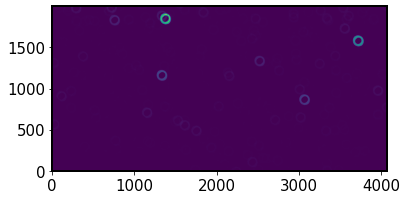

In [125]:
plt.imshow(intraImage.image.array, origin='lower')

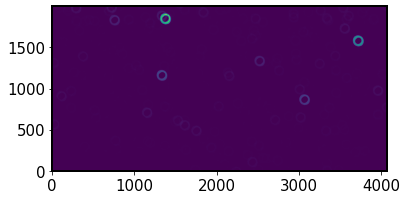

In [126]:
plt.imshow(intraImage.image.array, origin='lower')

In [13]:
# given one pair of stamps ...
#zerArray = []

configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

In [4]:
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import DefocalType, CamType, CentroidFindType





In [15]:
# now instead of calling 
# wfEsti = WfEstimator(instDir, algoDir)
# I dig inside it 

# this is part of the init 
inst = Instrument(instDir)
algo = Algorithm(algoDir)

imgIntra = CompensableImage()
imgExtra = CompensableImage()

opticalModel = ""
sizeInPix = 0

In [16]:
# now get the camera type and defocal distance
# inside estimateZernikes()
# instName gets specified in the config,
# and does not get overridden for CWFS
# https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L134
instName='lsst'    
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

In [17]:
# now instead of calling 
# wfEsti.config(
#     sizeInPix=self.donutStampSize,
#     camType=camType,
#     opticalModel=self.opticalModel,
#     defocalDisInMm=defocalDisInMm,
# )

# I update the parameters 
opticalModel = 'offAxis'
# Update the instrument name
#donutStampSize = 160 # px 
#sizeInPix = donutStampSize
sizeInPix = 160# int(sizeInPix)

inst.config(
    camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm
)

# choose the solver for the algorithm 
solver = 'exp' # by default 
debugLevel=0 # 1 to 3 
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

In [18]:
# now we'd normally loop over donut images 

#for now , just choose the first pair... 
i=0
#for donutExtra, donutIntra in zip(donutStampsExtra, donutStampsIntra):
donutExtra = donutStampsExtra[i]
donutIntra = donutStampsIntra[i]

fieldXYExtra = donutExtra.calcFieldXY()
fieldXYIntra = donutIntra.calcFieldXY()

camera = donutExtra.getCamera()
detectorExtra = camera.get(donutExtra.detector_name)
detectorIntra = camera.get(donutIntra.detector_name)


# Rotate any sensors that are not lined up with the focal plane.
# Mostly just for the corner wavefront sensors. The negative sign
# creates the correct rotation based upon closed loop tests
# with R04 and R40 corner sensors.
eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()



First try just offsetting the extra-focal compensable image by dx,dy degrees 

In [59]:
def plot_comp_img(imgIntra,imgExtra,i, title='before'):
    for img, label in zip([imgIntra,imgExtra],
                          ['intra','extra']):
        fig,axs = plt.subplots(2,3,figsize=(12,8))
        ax = np.ravel(axs)
        mask_pupil = img.getNonPaddedMask()
        mask_comp = img.getPaddedMask()
        image = img.getImg()
        ax[0].imshow(mask_pupil, origin='lower')
        ax[0].set_title('mask_pupil')
        ax[1].imshow(mask_comp,origin='lower')
        ax[1].set_title('mask_comp')
        ax[2].imshow(image,origin='lower')
        ax[2].set_title('img')
        ax[3].imshow(image/mask_pupil,origin='lower')
        ax[4].imshow(image/mask_comp,origin='lower')
        ax[5].axis('off')
        fig.suptitle(sensor+f' donut {i}'+f' {label} {title} fitting', fontsize=17)

In [19]:
for dx in np.linspace(0,0.3,10):
    #dx = 0.1 # degrees 
    dy = dx 
    
    radialOffsetDegrees = np.sqrt(dx**2.0+dy**2.0)
    
    # convert the x,y offset of the mask from degrees to pixels via pixelScale
    radialOffsetPixels = radialOffsetDegrees*3600*pixelScale
    
    print(dx,dy,radialOffsetDegrees,radialOffsetPixels)

0.0 0.0 0.0 0.0
0.03333333333333333 0.03333333333333333 0.04714045207910317 33.94112549353765
0.06666666666666667 0.06666666666666667 0.09428090415820634 67.8822509870753
0.1 0.1 0.14142135623730953 101.82337648061295
0.13333333333333333 0.13333333333333333 0.18856180831641267 135.7645019741506
0.16666666666666666 0.16666666666666666 0.23570226039551584 169.70562746768823
0.2 0.2 0.28284271247461906 203.6467529612259
0.23333333333333334 0.23333333333333334 0.3299831645537222 237.58787845476354
0.26666666666666666 0.26666666666666666 0.37712361663282534 271.5290039483012
0.3 0.3 0.4242640687119285 305.4701294418388


Explore pixel offsets up to 80 pixels, i.e. half of the template

/tmp/ipykernel_3042446/2145110933.py:15: RuntimeWarning: invalid value encountered in true_divide
  ax[3].imshow(image/mask_pupil,origin='lower')
/tmp/ipykernel_3042446/2145110933.py:16: RuntimeWarning: invalid value encountered in true_divide
  ax[4].imshow(image/mask_comp,origin='lower')
/tmp/ipykernel_3042446/2145110933.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax[3].imshow(image/mask_pupil,origin='lower')


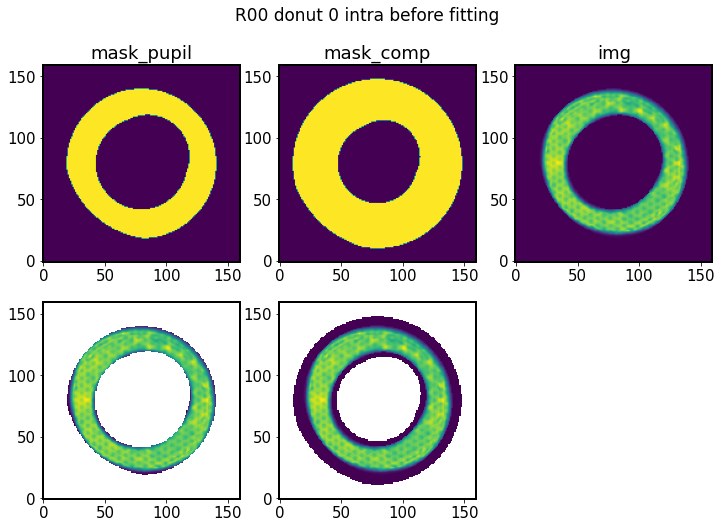

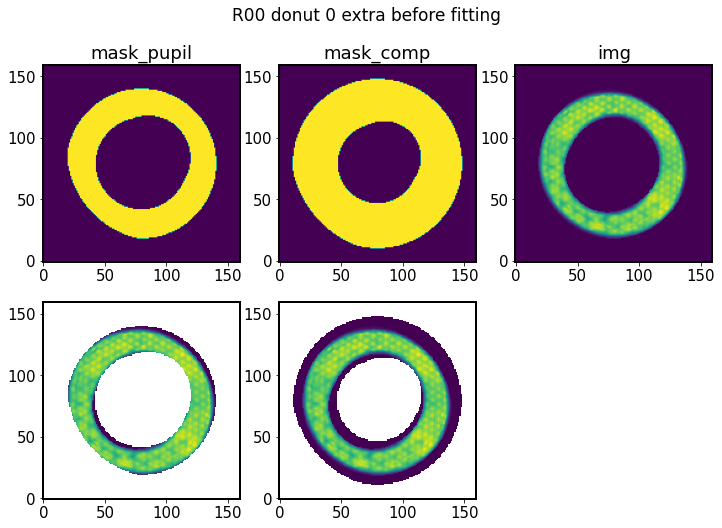

In [39]:
plot_comp_img(imgIntra,imgExtra,i)

In [22]:
offsetDegreesList = []
for offsetPixels in np.linspace(0,80,10):
    offsetArcsec  = offsetPixels*pixelScale
    offsetDegrees = offsetArcsec / 3600.
    print(offsetPixels, offsetArcsec, offsetDegrees)
    offsetDegreesList.append(offsetDegrees)

0.0 0.0 0.0
8.88888888888889 1.7777777775988204 0.0004938271604441168
17.77777777777778 3.5555555551976408 0.0009876543208882337
26.666666666666668 5.333333332796461 0.0014814814813323503
35.55555555555556 7.1111111103952815 0.0019753086417764673
44.44444444444444 8.888888887994101 0.0024691358022205837
53.333333333333336 10.666666665592922 0.0029629629626647005
62.22222222222223 12.444444443191744 0.003456790123108818
71.11111111111111 14.222222220790563 0.003950617283552935
80.0 15.999999998389383 0.004444444443997051


In [43]:
offsetDegreesList

[0.0,
 0.0004938271604441168,
 0.0009876543208882337,
 0.0014814814813323503,
 0.0019753086417764673,
 0.0024691358022205837,
 0.0029629629626647005,
 0.003456790123108818,
 0.003950617283552935,
 0.004444444443997051]

## Grid of dx,dy : vary fieldXYExtra, fieldXYIntra

Do the experiment of offsetting where the mask is calculated for in a grid of dx, dy. First change for the extra-focal donut only, then change from intra-focal donut only. 

In [5]:
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import DefocalType, CamType, CentroidFindType
from scipy.ndimage import rotate


In [6]:
#################################
### STEP 1 :  Load the stamps
#################################

repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'

# iterate over all sensors
#for sensor in ['R00','R40','R44','R04']: 
    
# schoose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)
# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()


configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# now instead of calling 
# wfEsti = WfEstimator(instDir, algoDir)
# I dig inside it 

# this is part of the init 
inst = Instrument(instDir)
algo = Algorithm(algoDir)

#imgIntra = CompensableImage()
#imgExtra = CompensableImage()

#opticalModel = ""
#sizeInPix = 0

# now get the camera type and defocal distance
# inside estimateZernikes()
# instName gets specified in the config,
# and does not get overridden for CWFS
# https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L134
instName='lsst'    
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

# now instead of calling 
# wfEsti.config( sizeInPix=self.donutStampSize, camType=camType,
#                opticalModel=self.opticalModel, defocalDisInMm=defocalDisInMm,
# )

# I update the parameters 
opticalModel = 'offAxis'
# Update the instrument name
#donutStampSize = 160 # px 
#sizeInPix = donutStampSize
sizeInPix = 160# int(sizeInPix)

inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

# choose the solver for the algorithm 
solver = 'exp' # by default 
debugLevel=0 # 1 to 3 
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

###
# now we'd normally loop over donut images 
###




In [75]:
print(sensor)

R00


In [7]:
#######################################
### STEP 2 :  Loop over donut pairs 
#######################################

# run those where I got weird results from the 
# adaptive circle of diffRms threshold 
Nextra = len(donutStampsExtra)
Nintra = len(donutStampsIntra)
print(f'There are {Nextra} extra donuts and {Nintra} intra donuts')

N = min(Nintra, Nextra)
print(f'We do {N} pairs')

for i in range(N): 
#for donutExtra, donutIntra in zip(donutStampsExtra, donutStampsIntra):
    donutExtra = donutStampsExtra[i]
    donutIntra = donutStampsIntra[i]
    print(f'\n Fitting sensor {sensor}, donut {i} ')

    fieldXYExtra = donutExtra.calcFieldXY()
    fieldXYIntra = donutIntra.calcFieldXY()

    #######################################
    ### STEP 2 A : fit baseline (no offset)
    #######################################

    camera = donutExtra.getCamera()
    detectorExtra = camera.get(donutExtra.detector_name)
    detectorIntra = camera.get(donutIntra.detector_name)

    # Rotate any sensors that are not lined up with the focal plane.
    eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
    eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

    # Now instead of running `wfEsti.setImg` method, do it by hand, since 
    # it inherits 'setImg' from 'CompensableImage' anyway...
    imgExtra.setImg(fieldXYExtra,
                    DefocalType.Extra,
                    image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

    imgIntra.setImg(fieldXYIntra,
                    DefocalType.Intra,
                    image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

    # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
    algo.reset()

    # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
    # simply calls algo:
    tol = 1e-3 # explicitly set the tolerance level ( this is default )
    algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
    zk0 = algo.getZer4UpInNm()

    fname = f'{sensor}_donut_{i}_no_offset_zk.txt'
    np.savetxt(fname, zk0)
    print(f'\nSaved the baseline fit as {fname}')
    

    #######################################
    ### STEP 2 B : fit grid of dx, dy offset 
    #######################################

    ## First applying change to the extra-focal mask, and then to the intra-focal mask
    for defocal in ['intra','extra']: # or extra 
        print(f'Fitting {sensor} donut {i} shifting {defocal} centroid ')

        dxInPixels = np.linspace(-100,100,20)
        dyInPixels = dxInPixels

        dxInDegrees = (dxInPixels* pixelScale) / 3600
        dyInDegrees = (dyInPixels* pixelScale) / 3600

        results = {}
        j =0 
        
        for dxDeg in dxInDegrees:
            for dyDeg in dyInDegrees:
                
                # calculate radial offset
                radialOffsetDegrees = np.sqrt(dxDeg**2.0+dyDeg**2.0)

                # convert the x,y offset of the mask from degrees to pixels via pixelScale
                radialOffsetPixels = ( radialOffsetDegrees * 3600 )/pixelScale

                dxPx = (dxDeg * 3600) / pixelScale
                dyPx = (dyDeg * 3600) / pixelScale
                
                results[j] = {'dxDeg':dxDeg, 'dyDeg':dyDeg, 
                              'dxPx':dxPx, 'dyPx':dyPx, 
                              'drDeg':radialOffsetDegrees,
                              'drPx':radialOffsetPixels, 
                              }

                 # do the fit 
                if defocal == 'extra':
                    fieldXYExtraUpd = (fieldXYExtra[0]+dxDeg, fieldXYExtra[1]+dyDeg)
                    fieldXYIntraUpd = fieldXYIntra

                elif defocal =='intra':
                    fieldXYExtraUpd = fieldXYExtra
                    fieldXYIntraUpd = (fieldXYIntra[0]+dxDeg, fieldXYIntra[1]+dyDeg)

                imgExtra.setImg(fieldXYExtraUpd,
                                DefocalType.Extra,
                                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

                imgIntra.setImg(fieldXYIntraUpd,
                                DefocalType.Intra,
                                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)


                # right after we set the image, the compensable image mask is empty - 
                # it is only calculated in algo
                # https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694
                maskScalingFactorLocal = 1
                boundaryT = algo.getBoundaryThickness()
                imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
                imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)

                # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
                algo.reset()

                # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
                # simply calls algo:
                tol = 1e-3 # explicitly set the tolerance level ( this is default )
                algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)
                zk = algo.getZer4UpInNm()
                
                # calculate diffMax, diffRms
                diffMax = np.max(np.abs(zk - zk0))
                diffRms = np.sqrt(np.sum(np.abs(zk - zk0) ** 2) / len(zk))

                # store the results 
                results[j]['diffMax'] = diffMax
                results[j]['diffRms'] = diffRms
                results[j]['zk'] = zk
                results[j]['imgExtraFieldXY'] = imgExtra.getFieldXY()
                results[j]['imgIntraFieldXY'] = imgIntra.getFieldXY()

                # increase the grid counter 
                j += 1 
                print(j, dxPx, dyPx, diffRms, )
        fname = f'{sensor}_donut_{i}_{defocal}_offset_square_grid.npy'
        print(f"saved {fname}")
        np.save(fname, results)



There are 9 extra donuts and 6 intra donuts
We do 6 pairs

 Fitting sensor R00, donut 0 

Saved the baseline fit as R00_donut_0_no_offset_zk.txt
Fitting R00 donut 0 shifting intra centroid 
1 -100.0 -100.0 1.4534983845316545
2 -100.0 -89.47368421052632 1.38230846523381
3 -100.0 -78.94736842105263 1.3150776375646187
4 -100.0 -68.42105263157895 1.245309080140928
5 -100.0 -57.89473684210526 1.1765132421438171
6 -100.0 -47.368421052631575 1.1088637879580026
7 -100.0 -36.84210526315789 0.9914448158949589
8 -100.0 -26.315789473684205 0.926999906927916
9 -100.0 -15.78947368421052 0.84732242706885
10 -100.0 -5.263157894736835 0.7884194253685882
11 -100.0 5.26315789473685 0.7313086464565396
12 -100.0 15.789473684210535 0.6797220392641671
13 -100.0 26.315789473684216 0.6334030627619468
14 -100.0 36.84210526315792 0.5935725922672829
15 -100.0 47.3684210526316 0.6137103266659469
16 -100.0 57.89473684210526 0.6057631073060769
17 -100.0 68.42105263157896 0.6079283531207448
18 -100.0 78.9473684210526

142 -26.315789473684205 -89.47368421052632 0.8562277499013362
143 -26.315789473684205 -78.94736842105263 0.7801769719578218
144 -26.315789473684205 -68.42105263157895 0.7044515735155791
145 -26.315789473684205 -57.89473684210526 0.62916822713873
146 -26.315789473684205 -47.368421052631575 0.5306241972334751
147 -26.315789473684205 -36.84210526315789 0.45660245006933786
148 -26.315789473684205 -26.315789473684205 0.3840767219177553
149 -26.315789473684205 -15.78947368421052 0.31394916669033035
150 -26.315789473684205 -5.263157894736835 0.2480988858058215
151 -26.315789473684205 5.26315789473685 0.18974370810312297
152 -26.315789473684205 15.789473684210535 0.14141299652539788
153 -26.315789473684205 26.315789473684216 0.155575317667254
154 -26.315789473684205 36.84210526315792 0.20091314808943322
155 -26.315789473684205 47.3684210526316 0.26166185728595925
156 -26.315789473684205 57.89473684210526 0.3294194178561541
157 -26.315789473684205 68.42105263157896 0.4006082029052914
158 -26.31

280 36.84210526315792 100.0 0.9557958887227864
281 47.3684210526316 -100.0 0.5975521773224939
282 47.3684210526316 -89.47368421052632 0.5041994045774819
283 47.3684210526316 -78.94736842105263 0.4382092201431427
284 47.3684210526316 -68.42105263157895 0.37673098487411133
285 47.3684210526316 -57.89473684210526 0.3224055839723897
286 47.3684210526316 -47.368421052631575 0.2794510699627896
287 47.3684210526316 -36.84210526315789 0.2536116973241691
288 47.3684210526316 -26.315789473684205 0.2496563791643807
289 47.3684210526316 -15.78947368421052 0.2808357605877921
290 47.3684210526316 -5.263157894736835 0.32692957833134273
291 47.3684210526316 5.26315789473685 0.3840007400153796
292 47.3684210526316 15.789473684210535 0.4462320636268609
293 47.3684210526316 26.315789473684216 0.51259071792191
294 47.3684210526316 36.84210526315792 0.5816860845873807
295 47.3684210526316 47.3684210526316 0.6526520147185354
296 47.3684210526316 57.89473684210526 0.7249293786333754
297 47.3684210526316 68.4

28 -89.47368421052632 -26.315789473684205 0.9188042708327878
29 -89.47368421052632 -15.78947368421052 0.911889074330679
30 -89.47368421052632 -5.263157894736835 0.9074409514289574
31 -89.47368421052632 5.26315789473685 0.9054304060426855
32 -89.47368421052632 15.789473684210535 0.9058437139578139
33 -89.47368421052632 26.315789473684216 0.9087376227448866
34 -89.47368421052632 36.84210526315792 0.9141321524362682
35 -89.47368421052632 47.3684210526316 0.9219374643655182
36 -89.47368421052632 57.89473684210526 0.93208579433474
37 -89.47368421052632 68.42105263157896 0.9445385375331568
38 -89.47368421052632 78.94736842105266 0.9592250872618896
39 -89.47368421052632 89.47368421052633 0.9760200320965191
40 -89.47368421052632 100.0 0.9947979343196504
41 -78.94736842105263 -100.0 1.0476578534867818
42 -78.94736842105263 -89.47368421052632 1.0012507380883553
43 -78.94736842105263 -78.94736842105263 0.9782539713350302
44 -78.94736842105263 -68.42105263157895 0.9604407425708974
45 -78.947368421

167 -15.78947368421052 -36.84210526315789 0.6000940323262437
168 -15.78947368421052 -26.315789473684205 0.5972748348231
169 -15.78947368421052 -15.78947368421052 0.3324489500042802
170 -15.78947368421052 -5.263157894736835 0.31991439102905567
171 -15.78947368421052 5.26315789473685 0.3257408019750634
172 -15.78947368421052 15.789473684210535 0.085698250643845
173 -15.78947368421052 26.315789473684216 0.1152510096326495
174 -15.78947368421052 36.84210526315792 0.15373990516115502
175 -15.78947368421052 47.3684210526316 0.231663544598355
176 -15.78947368421052 57.89473684210526 0.26126401350229794
177 -15.78947368421052 68.42105263157896 0.2954144840021314
178 -15.78947368421052 78.94736842105266 0.3327276383744027
179 -15.78947368421052 89.47368421052633 0.3722156947183024
180 -15.78947368421052 100.0 0.41325101149702087
181 -5.263157894736835 -100.0 0.6445757498812201
182 -5.263157894736835 -89.47368421052632 0.62213048594628
183 -5.263157894736835 -78.94736842105263 0.6025570991583903

307 57.89473684210526 -36.84210526315789 0.5092797179129601
308 57.89473684210526 -26.315789473684205 0.502217807534326
309 57.89473684210526 -15.78947368421052 0.4994846899021018
310 57.89473684210526 -5.263157894736835 0.5011660011124095
311 57.89473684210526 5.26315789473685 0.5072307357716442
312 57.89473684210526 15.789473684210535 0.5174949709547875
313 57.89473684210526 26.315789473684216 0.5316477435410547
314 57.89473684210526 36.84210526315792 0.5494369042501869
315 57.89473684210526 47.3684210526316 0.570559451415042
316 57.89473684210526 57.89473684210526 0.5946329591032519
317 57.89473684210526 68.42105263157896 0.6830239967184182
318 57.89473684210526 78.94736842105266 0.7058039231473549
319 57.89473684210526 89.47368421052633 0.7336727829537192
320 57.89473684210526 100.0 0.82406393783709
321 68.42105263157896 -100.0 0.656164556097299
322 68.42105263157896 -89.47368421052632 0.6315607199427327
323 68.42105263157896 -78.94736842105263 0.6095578515136915
324 68.42105263157

54 -78.94736842105263 36.84210526315792 9663.756193125713
55 -78.94736842105263 47.3684210526316 4429.669517206847
56 -78.94736842105263 57.89473684210526 3819.126266616546
57 -78.94736842105263 68.42105263157896 3679.3497971578563
58 -78.94736842105263 78.94736842105266 1835.7935705152672
59 -78.94736842105263 89.47368421052633 13048.235534238407
60 -78.94736842105263 100.0 16578.1044853626
61 -68.42105263157895 -100.0 31112.733492452946
62 -68.42105263157895 -89.47368421052632 5483.340072052151
63 -68.42105263157895 -78.94736842105263 6069.857948936837
64 -68.42105263157895 -68.42105263157895 15975.082445730293
65 -68.42105263157895 -57.89473684210526 16298.736287681235
66 -68.42105263157895 -47.368421052631575 6492.676506958519
67 -68.42105263157895 -36.84210526315789 6499.336299552627
68 -68.42105263157895 -26.315789473684205 6346.8938202989875
69 -68.42105263157895 -15.78947368421052 6696.416939705528
70 -68.42105263157895 -5.263157894736835 10255.368624580311
71 -68.4210526315789

194 -5.263157894736835 36.84210526315792 9929.78240955646
195 -5.263157894736835 47.3684210526316 9919.56107603493
196 -5.263157894736835 57.89473684210526 8948.652608433691
197 -5.263157894736835 68.42105263157896 8305.057163974589
198 -5.263157894736835 78.94736842105266 8304.008764086773
199 -5.263157894736835 89.47368421052633 7967.545053362325
200 -5.263157894736835 100.0 7405.882555796547
201 5.26315789473685 -100.0 14645.622126512808
202 5.26315789473685 -89.47368421052632 14645.523155597326
203 5.26315789473685 -78.94736842105263 12119.41930189602
204 5.26315789473685 -68.42105263157895 12135.311153394006
205 5.26315789473685 -57.89473684210526 16210.024342294922
206 5.26315789473685 -47.368421052631575 12460.566423017535
207 5.26315789473685 -36.84210526315789 16957.5880407045
208 5.26315789473685 -26.315789473684205 3706.8825043951274
209 5.26315789473685 -15.78947368421052 3258.754581980129
210 5.26315789473685 -5.263157894736835 207.68695981433464
211 5.26315789473685 5.263

337 68.42105263157896 68.42105263157896 8926.91027133265
338 68.42105263157896 78.94736842105266 30735.226870576298
339 68.42105263157896 89.47368421052633 13731.78485688977
340 68.42105263157896 100.0 18281.857263062153
341 78.94736842105266 -100.0 21711.26913058548
342 78.94736842105266 -89.47368421052632 16461.209891096354
343 78.94736842105266 -78.94736842105263 21376.107315642963
344 78.94736842105266 -68.42105263157895 21313.037295224774
345 78.94736842105266 -57.89473684210526 8954.699084356596
346 78.94736842105266 -47.368421052631575 8030.184485077918
347 78.94736842105266 -36.84210526315789 9218.976862922718
348 78.94736842105266 -26.315789473684205 8030.619115567128
349 78.94736842105266 -15.78947368421052 9803.525192180798
350 78.94736842105266 -5.263157894736835 8259.352447649666
351 78.94736842105266 5.26315789473685 8556.59201424974
352 78.94736842105266 15.789473684210535 145678.43069527828
353 78.94736842105266 26.315789473684216 20361.069371600934
354 78.9473684210526

86 -57.89473684210526 -47.368421052631575 15704.01188369717
87 -57.89473684210526 -36.84210526315789 89575.7733608028
88 -57.89473684210526 -26.315789473684205 90294.52821035271
89 -57.89473684210526 -15.78947368421052 90755.79026777695
90 -57.89473684210526 -5.263157894736835 19155.788229828788
91 -57.89473684210526 5.26315789473685 8129.439951446917
92 -57.89473684210526 15.789473684210535 6187.278226395634
93 -57.89473684210526 26.315789473684216 16478.13728059665
94 -57.89473684210526 36.84210526315792 1630.3566085981513
95 -57.89473684210526 47.3684210526316 1657.884335752243
96 -57.89473684210526 57.89473684210526 2708.5371075774437
97 -57.89473684210526 68.42105263157896 1712.6527160652015
98 -57.89473684210526 78.94736842105266 1910.981037826822
99 -57.89473684210526 89.47368421052633 1936.5191880220514
100 -57.89473684210526 100.0 1960.3889183111169
101 -47.368421052631575 -100.0 10684.511487156127
102 -47.368421052631575 -89.47368421052632 8244.324776722402
103 -47.3684210526

226 15.789473684210535 -47.368421052631575 19755.618987795642
227 15.789473684210535 -36.84210526315789 21582.82739529981
228 15.789473684210535 -26.315789473684205 15146.29378848228
229 15.789473684210535 -15.78947368421052 202.58260215894325
230 15.789473684210535 -5.263157894736835 20659.950491036496
231 15.789473684210535 5.26315789473685 20674.67798429937
232 15.789473684210535 15.789473684210535 5575.41726363048
233 15.789473684210535 26.315789473684216 17574.602671374843
234 15.789473684210535 36.84210526315792 19085.572833155413
235 15.789473684210535 47.3684210526316 19098.91306700774
236 15.789473684210535 57.89473684210526 19113.086559839394
237 15.789473684210535 68.42105263157896 19129.725322276332
238 15.789473684210535 78.94736842105266 18903.439400756106
239 15.789473684210535 89.47368421052633 19164.791014562506
240 15.789473684210535 100.0 19182.632188587897
241 26.315789473684216 -100.0 15293.68877246643
242 26.315789473684216 -89.47368421052632 15303.17680179795
243

368 89.47368421052633 -26.315789473684205 17253.934058573595
369 89.47368421052633 -15.78947368421052 17252.896530645143
370 89.47368421052633 -5.263157894736835 17382.308722920912
371 89.47368421052633 5.26315789473685 23284.420550351664
372 89.47368421052633 15.789473684210535 23323.00399843146
373 89.47368421052633 26.315789473684216 76474.94792430682
374 89.47368421052633 36.84210526315792 76361.06411835515
375 89.47368421052633 47.3684210526316 11609.749614147868
376 89.47368421052633 57.89473684210526 9563.706517210665
377 89.47368421052633 68.42105263157896 12720.563556657105
378 89.47368421052633 78.94736842105266 12721.011558289074
379 89.47368421052633 89.47368421052633 12713.822906736352
380 89.47368421052633 100.0 13931.226136655856
381 100.0 -100.0 21361.57474158625
382 100.0 -89.47368421052632 76487.95295646004
383 100.0 -78.94736842105263 76499.88230607077
384 100.0 -68.42105263157895 76498.28719348754
385 100.0 -57.89473684210526 46853.19380079428
386 100.0 -47.36842105

114 -47.368421052631575 36.84210526315792 0.2888631063121098
115 -47.368421052631575 47.3684210526316 0.30174946101112016
116 -47.368421052631575 57.89473684210526 0.37879186710668306
117 -47.368421052631575 68.42105263157896 0.5184447681415608
118 -47.368421052631575 78.94736842105266 0.5977289596774538
119 -47.368421052631575 89.47368421052633 0.667188964112522
120 -47.368421052631575 100.0 0.7273082232195437
121 -36.84210526315789 -100.0 1.3203026583952475
122 -36.84210526315789 -89.47368421052632 1.2098693462682875
123 -36.84210526315789 -78.94736842105263 1.1253294713275321
124 -36.84210526315789 -68.42105263157895 1.0414234274992238
125 -36.84210526315789 -57.89473684210526 0.8511068099724173
126 -36.84210526315789 -47.368421052631575 0.6909076792753859
127 -36.84210526315789 -36.84210526315789 0.6047261426654994
128 -36.84210526315789 -26.315789473684205 0.5202697455441558
129 -36.84210526315789 -15.78947368421052 0.4043059468171331
130 -36.84210526315789 -5.263157894736835 0.32

252 26.315789473684216 15.789473684210535 0.3157121398790404
253 26.315789473684216 26.315789473684216 0.42705148643552915
254 26.315789473684216 36.84210526315792 0.5103411596848344
255 26.315789473684216 47.3684210526316 4.6180931453013105
256 26.315789473684216 57.89473684210526 4.632580416595171
257 26.315789473684216 68.42105263157896 4.648479224586477
258 26.315789473684216 78.94736842105266 0.8277799908708158
259 26.315789473684216 89.47368421052633 0.913483260050142
260 26.315789473684216 100.0 0.9995063678645928
261 36.84210526315792 -100.0 0.7330471778663727
262 36.84210526315792 -89.47368421052632 0.6365661428818338
263 36.84210526315792 -78.94736842105263 0.5675466408673743
264 36.84210526315792 -68.42105263157895 0.49069449869061127
265 36.84210526315792 -57.89473684210526 0.42191620188972384
266 36.84210526315792 -47.368421052631575 0.35917015175455297
267 36.84210526315792 -36.84210526315789 0.3093719710312743
268 36.84210526315792 -26.315789473684205 0.23324008470849483

396 100.0 57.89473684210526 1.1469622277432374
397 100.0 68.42105263157896 1.2261329758392223
398 100.0 78.94736842105266 1.3064239760712448
399 100.0 89.47368421052633 1.365999075370828
400 100.0 100.0 1.4347037329117718
saved R00_donut_2_intra_offset_square_grid.npy
Fitting R00 donut 2 shifting extra centroid 
1 -100.0 -100.0 0.651648526984018
2 -100.0 -89.47368421052632 0.6210567011322214
3 -100.0 -78.94736842105263 0.5916424354923966
4 -100.0 -68.42105263157895 0.563842114310129
5 -100.0 -57.89473684210526 0.5379214045975342
6 -100.0 -47.368421052631575 0.5141104113162817
7 -100.0 -36.84210526315789 0.4927632059461596
8 -100.0 -26.315789473684205 0.4742595706932354
9 -100.0 -15.78947368421052 0.45892777342589125
10 -100.0 -5.263157894736835 0.44708528101886863
11 -100.0 5.26315789473685 0.4388569499916774
12 -100.0 15.789473684210535 0.43474692983598984
13 -100.0 26.315789473684216 0.43457649535976894
14 -100.0 36.84210526315792 0.4385094931876224
15 -100.0 47.3684210526316 0.44642

139 -36.84210526315789 89.47368421052633 0.45733057903251556
140 -36.84210526315789 100.0 0.4905638058866728
141 -26.315789473684205 -100.0 0.4381067903154358
142 -26.315789473684205 -89.47368421052632 0.39762841735694054
143 -26.315789473684205 -78.94736842105263 0.3575214968271247
144 -26.315789473684205 -68.42105263157895 0.31797322730160155
145 -26.315789473684205 -57.89473684210526 0.27915351000503974
146 -26.315789473684205 -47.368421052631575 0.24138487815330162
147 -26.315789473684205 -36.84210526315789 0.20529706292073455
148 -26.315789473684205 -26.315789473684205 0.1718861555600308
149 -26.315789473684205 -15.78947368421052 0.14310110157735742
150 -26.315789473684205 -5.263157894736835 0.12241256892461394
151 -26.315789473684205 5.26315789473685 0.11424928319456103
152 -26.315789473684205 15.789473684210535 0.1212108851547367
153 -26.315789473684205 26.315789473684216 0.14090843060217248
154 -26.315789473684205 36.84210526315792 0.2903193623235668
155 -26.315789473684205 47.

277 36.84210526315792 68.42105263157896 0.3450830637877444
278 36.84210526315792 78.94736842105266 0.3855965903416957
279 36.84210526315792 89.47368421052633 0.42642416978164044
280 36.84210526315792 100.0 0.46749212838746584
281 47.3684210526316 -100.0 0.4133818356380301
282 47.3684210526316 -89.47368421052632 0.3774330933722011
283 47.3684210526316 -78.94736842105263 0.34293287176079623
284 47.3684210526316 -68.42105263157895 0.3101644219622388
285 47.3684210526316 -57.89473684210526 0.2798274079022672
286 47.3684210526316 -47.368421052631575 0.25312772901479463
287 47.3684210526316 -36.84210526315789 0.23101893346421068
288 47.3684210526316 -26.315789473684205 0.215039559810862
289 47.3684210526316 -15.78947368421052 0.2065833421486996
290 47.3684210526316 -5.263157894736835 0.13174676464516366
291 47.3684210526316 5.26315789473685 0.15179412696055444
292 47.3684210526316 15.789473684210535 0.17952408554984364
293 47.3684210526316 26.315789473684216 0.21198534808262845
294 47.368421

23 -89.47368421052632 -78.94736842105263 52.36571113874652
24 -89.47368421052632 -68.42105263157895 52.55625189306874
25 -89.47368421052632 -57.89473684210526 51.54577376415959
26 -89.47368421052632 -47.368421052631575 49.953875290389824
27 -89.47368421052632 -36.84210526315789 49.3143287953612
28 -89.47368421052632 -26.315789473684205 19.119804577491767
29 -89.47368421052632 -15.78947368421052 15.365884570802338
30 -89.47368421052632 -5.263157894736835 10.55475587131309
31 -89.47368421052632 5.26315789473685 10.053241299858275
32 -89.47368421052632 15.789473684210535 11.307395815184515
33 -89.47368421052632 26.315789473684216 10.233702089782101
34 -89.47368421052632 36.84210526315792 7.355951052654494
35 -89.47368421052632 47.3684210526316 10.087690809747706
36 -89.47368421052632 57.89473684210526 8.151578392040756
37 -89.47368421052632 68.42105263157896 6.635728847200585
38 -89.47368421052632 78.94736842105266 17.729031916024145
39 -89.47368421052632 89.47368421052633 2.2291490516989

164 -15.78947368421052 -68.42105263157895 8.92077582370245
165 -15.78947368421052 -57.89473684210526 11.081828212890402
166 -15.78947368421052 -47.368421052631575 10.410822806887232
167 -15.78947368421052 -36.84210526315789 8.272569601220074
168 -15.78947368421052 -26.315789473684205 9.34420016828764
169 -15.78947368421052 -15.78947368421052 9.267786389241722
170 -15.78947368421052 -5.263157894736835 5.95002104364742
171 -15.78947368421052 5.26315789473685 9.136758808273076
172 -15.78947368421052 15.789473684210535 1.8241997856245467
173 -15.78947368421052 26.315789473684216 5.565658049298901
174 -15.78947368421052 36.84210526315792 7.917820692255589
175 -15.78947368421052 47.3684210526316 10.633992554437304
176 -15.78947368421052 57.89473684210526 30.414776648098158
177 -15.78947368421052 68.42105263157896 55.47815734080222
178 -15.78947368421052 78.94736842105266 56.425717671687984
179 -15.78947368421052 89.47368421052633 56.30886695442901
180 -15.78947368421052 100.0 57.122649485852

306 57.89473684210526 -47.368421052631575 4.539942479590471
307 57.89473684210526 -36.84210526315789 8.6668560933314
308 57.89473684210526 -26.315789473684205 10.717463424956625
309 57.89473684210526 -15.78947368421052 31.497311978120443
310 57.89473684210526 -5.263157894736835 32.22901528894805
311 57.89473684210526 5.26315789473685 56.16302771173204
312 57.89473684210526 15.789473684210535 56.9980310715769
313 57.89473684210526 26.315789473684216 57.143652462851435
314 57.89473684210526 36.84210526315792 60.77987272684107
315 57.89473684210526 47.3684210526316 67.49733298452458
316 57.89473684210526 57.89473684210526 71.44221172615337
317 57.89473684210526 68.42105263157896 72.86523574978341
318 57.89473684210526 78.94736842105266 75.21768620527348
319 57.89473684210526 89.47368421052633 76.09906162242089
320 57.89473684210526 100.0 76.9864718295161
321 68.42105263157896 -100.0 8.62615424057108
322 68.42105263157896 -89.47368421052632 6.663695730799581
323 68.42105263157896 -78.94736

55 -78.94736842105263 47.3684210526316 0.3590203841196658
56 -78.94736842105263 57.89473684210526 0.33042683321138194
57 -78.94736842105263 68.42105263157896 0.3171942868537682
58 -78.94736842105263 78.94736842105266 0.32119319949900094
59 -78.94736842105263 89.47368421052633 0.3418792939663789
60 -78.94736842105263 100.0 0.3765311192585717
61 -68.42105263157895 -100.0 10.91097314929947
62 -68.42105263157895 -89.47368421052632 10.905275833881355
63 -68.42105263157895 -78.94736842105263 0.9281975671452938
64 -68.42105263157895 -68.42105263157895 0.8583982613057769
65 -68.42105263157895 -57.89473684210526 0.7894281984465823
66 -68.42105263157895 -47.368421052631575 0.721621032312637
67 -68.42105263157895 -36.84210526315789 0.6552932129317859
68 -68.42105263157895 -26.315789473684205 0.5908737254324982
69 -68.42105263157895 -15.78947368421052 0.5475180864287216
70 -68.42105263157895 -5.263157894736835 0.4908909877624387
71 -68.42105263157895 5.26315789473685 0.4395733809557384
72 -68.4210

193 -5.263157894736835 26.315789473684216 0.15380577181927801
194 -5.263157894736835 36.84210526315792 0.22790517423807474
195 -5.263157894736835 47.3684210526316 0.3023553929438355
196 -5.263157894736835 57.89473684210526 0.37696672644811136
197 -5.263157894736835 68.42105263157896 0.45168781074686654
198 -5.263157894736835 78.94736842105266 0.5264838008828717
199 -5.263157894736835 89.47368421052633 0.601275286021348
200 -5.263157894736835 100.0 0.6763808544912631
201 5.26315789473685 -100.0 0.6160172990541196
202 5.26315789473685 -89.47368421052632 0.5512133139322952
203 5.26315789473685 -78.94736842105263 0.4890692904428196
204 5.26315789473685 -68.42105263157895 0.4308987737643082
205 5.26315789473685 -57.89473684210526 0.3785177682067201
206 5.26315789473685 -47.368421052631575 0.32609635469867876
207 5.26315789473685 -36.84210526315789 0.2903164988115359
208 5.26315789473685 -26.315789473684205 0.27074814609291564
209 5.26315789473685 -15.78947368421052 0.2709177701419753
210 5.

333 68.42105263157896 26.315789473684216 0.7027878978319736
334 68.42105263157896 36.84210526315792 0.7450078490825035
335 68.42105263157896 47.3684210526316 0.8107304845058485
336 68.42105263157896 57.89473684210526 0.8819672450642229
337 68.42105263157896 68.42105263157896 0.9537307373843761
338 68.42105263157896 78.94736842105266 1.0258595548438767
339 68.42105263157896 89.47368421052633 1.0983452812374992
340 68.42105263157896 100.0 1.1711226056142563
341 78.94736842105266 -100.0 0.48565028422878265
342 78.94736842105266 -89.47368421052632 0.4795191935450143
343 78.94736842105266 -78.94736842105263 0.4850054357746239
344 78.94736842105266 -68.42105263157895 0.5016950947411691
345 78.94736842105266 -57.89473684210526 0.5285347366676995
346 78.94736842105266 -47.368421052631575 0.5641280914543662
347 78.94736842105266 -36.84210526315789 0.429202727757771
348 78.94736842105266 -26.315789473684205 0.477576153492235
349 78.94736842105266 -15.78947368421052 0.532199882004791
350 78.94736

80 -68.42105263157895 100.0 15.91041546930969
81 -57.89473684210526 -100.0 40.63835254796328
82 -57.89473684210526 -89.47368421052632 89.5037600227852
83 -57.89473684210526 -78.94736842105263 82.41357021789388
84 -57.89473684210526 -68.42105263157895 80.82237929915385
85 -57.89473684210526 -57.89473684210526 78.0064211012899
86 -57.89473684210526 -47.368421052631575 57.789198612392596
87 -57.89473684210526 -36.84210526315789 50.841523131115444
88 -57.89473684210526 -26.315789473684205 45.21011893174851
89 -57.89473684210526 -15.78947368421052 36.17236494261744
90 -57.89473684210526 -5.263157894736835 32.734816684766415
91 -57.89473684210526 5.26315789473685 35.75555886733843
92 -57.89473684210526 15.789473684210535 34.31557354764091
93 -57.89473684210526 26.315789473684216 40.67867569029642
94 -57.89473684210526 36.84210526315792 33.40972252246874
95 -57.89473684210526 47.3684210526316 11.062155153733997
96 -57.89473684210526 57.89473684210526 0.5097302650541117
97 -57.89473684210526 6

220 5.26315789473685 100.0 44.500589138308804
221 15.789473684210535 -100.0 43.99327597346354
222 15.789473684210535 -89.47368421052632 42.16055394435296
223 15.789473684210535 -78.94736842105263 33.59355589371842
224 15.789473684210535 -68.42105263157895 37.32859359967817
225 15.789473684210535 -57.89473684210526 26.62296516695679
226 15.789473684210535 -47.368421052631575 31.070250640772073
227 15.789473684210535 -36.84210526315789 34.797630885558625
228 15.789473684210535 -26.315789473684205 8.413297117770755
229 15.789473684210535 -15.78947368421052 20.091951520424132
230 15.789473684210535 -5.263157894736835 19.244118502585927
231 15.789473684210535 5.26315789473685 15.70029767197658
232 15.789473684210535 15.789473684210535 17.50746949463403
233 15.789473684210535 26.315789473684216 19.482225221133515
234 15.789473684210535 36.84210526315792 23.453976454173645
235 15.789473684210535 47.3684210526316 19.017959028932196
236 15.789473684210535 57.89473684210526 20.992105350112134
23

362 89.47368421052633 -89.47368421052632 18.546425759299684
363 89.47368421052633 -78.94736842105263 15.68264208109599
364 89.47368421052633 -68.42105263157895 14.814239205726645
365 89.47368421052633 -57.89473684210526 16.45104991904806
366 89.47368421052633 -47.368421052631575 20.28501110330445
367 89.47368421052633 -36.84210526315789 23.128401979989725
368 89.47368421052633 -26.315789473684205 20.37897136567088
369 89.47368421052633 -15.78947368421052 21.848163469568426
370 89.47368421052633 -5.263157894736835 24.605577471507303
371 89.47368421052633 5.26315789473685 37.561529483154665
372 89.47368421052633 15.789473684210535 43.59219090154853
373 89.47368421052633 26.315789473684216 49.13565615937689
374 89.47368421052633 36.84210526315792 50.958928053113226
375 89.47368421052633 47.3684210526316 55.94400013668618
376 89.47368421052633 57.89473684210526 57.045759453956656
377 89.47368421052633 68.42105263157896 60.73461636909452
378 89.47368421052633 78.94736842105266 64.8991590292

110 -47.368421052631575 -5.263157894736835 0.38382796215815684
111 -47.368421052631575 5.26315789473685 3.2778161733375977
112 -47.368421052631575 15.789473684210535 0.27400401161571175
113 -47.368421052631575 26.315789473684216 21.191194106490883
114 -47.368421052631575 36.84210526315792 21.24739648787722
115 -47.368421052631575 47.3684210526316 0.23101554318861584
116 -47.368421052631575 57.89473684210526 21.360065626445945
117 -47.368421052631575 68.42105263157896 21.416654106350016
118 -47.368421052631575 78.94736842105266 21.473304854657194
119 -47.368421052631575 89.47368421052633 0.8653214718895366
120 -47.368421052631575 100.0 0.8208531324716277
121 -36.84210526315789 -100.0 1.6824384560523293
122 -36.84210526315789 -89.47368421052632 1.610418710652208
123 -36.84210526315789 -78.94736842105263 1.5388842456590168
124 -36.84210526315789 -68.42105263157895 1.5337994377317032
125 -36.84210526315789 -57.89473684210526 0.6556554725299443
126 -36.84210526315789 -47.368421052631575 0.5

249 26.315789473684216 -15.78947368421052 1.0119639441262647
250 26.315789473684216 -5.263157894736835 0.9472165385820084
251 26.315789473684216 5.26315789473685 0.8843626229853437
252 26.315789473684216 15.789473684210535 0.8237681405251559
253 26.315789473684216 26.315789473684216 0.7659774634830431
254 26.315789473684216 36.84210526315792 0.7117538574026931
255 26.315789473684216 47.3684210526316 0.6619241680142672
256 26.315789473684216 57.89473684210526 0.6175992434818881
257 26.315789473684216 68.42105263157896 0.5800647429990534
258 26.315789473684216 78.94736842105266 22.019998259553876
259 26.315789473684216 89.47368421052633 22.076956183384006
260 26.315789473684216 100.0 22.134303867262776
261 36.84210526315792 -100.0 1.2520141724173295
262 36.84210526315792 -89.47368421052632 1.1819370961310467
263 36.84210526315792 -78.94736842105263 1.1128026265281714
264 36.84210526315792 -68.42105263157895 1.0446571557261197
265 36.84210526315792 -57.89473684210526 0.9777864902699698
26

393 100.0 26.315789473684216 22.282934210736027
394 100.0 36.84210526315792 22.34019868853629
395 100.0 47.3684210526316 22.397602695521964
396 100.0 57.89473684210526 22.455107392337815
397 100.0 68.42105263157896 22.512803815736287
398 100.0 78.94736842105266 22.570579767913266
399 100.0 89.47368421052633 22.666139998281178
400 100.0 100.0 22.724022692799977
saved R00_donut_4_extra_offset_square_grid.npy

 Fitting sensor R00, donut 5 

Saved the baseline fit as R00_donut_5_no_offset_zk.txt
Fitting R00 donut 5 shifting intra centroid 
1 -100.0 -100.0 7.0470709636356235
2 -100.0 -89.47368421052632 7.108327805513294
3 -100.0 -78.94736842105263 7.17019504672174
4 -100.0 -68.42105263157895 7.2326726580883
5 -100.0 -57.89473684210526 7.303665584408381
6 -100.0 -47.368421052631575 7.217519608843963
7 -100.0 -36.84210526315789 7.280290245965379
8 -100.0 -26.315789473684205 7.343706205252263
9 -100.0 -15.78947368421052 7.445080563968792
10 -100.0 -5.263157894736835 7.506194900334797
11 -100.0

138 -36.84210526315789 78.94736842105266 8.018154714933578
139 -36.84210526315789 89.47368421052633 8.130899936618773
140 -36.84210526315789 100.0 8.196088029240657
141 -26.315789473684205 -100.0 7.2655031169889925
142 -26.315789473684205 -89.47368421052632 0.8204072887291793
143 -26.315789473684205 -78.94736842105263 7.291843474857767
144 -26.315789473684205 -68.42105263157895 7.303845962111582
145 -26.315789473684205 -57.89473684210526 7.36564357557721
146 -26.315789473684205 -47.368421052631575 7.427959185853692
147 -26.315789473684205 -36.84210526315789 7.456714476003193
148 -26.315789473684205 -26.315789473684205 7.519715017887161
149 -26.315789473684205 -15.78947368421052 7.58329102759949
150 -26.315789473684205 -5.263157894736835 7.64604141252251
151 -26.315789473684205 5.26315789473685 7.646671267427897
152 -26.315789473684205 15.789473684210535 7.709761700968147
153 -26.315789473684205 26.315789473684216 7.7636291408298685
154 -26.315789473684205 36.84210526315792 7.8273810531

278 36.84210526315792 78.94736842105266 8.1471967200944
279 36.84210526315792 89.47368421052633 8.21263050837849
280 36.84210526315792 100.0 8.278495670499003
281 47.3684210526316 -100.0 7.392199369657383
282 47.3684210526316 -89.47368421052632 7.41412849605546
283 47.3684210526316 -78.94736842105263 7.476482192230152
284 47.3684210526316 -68.42105263157895 7.462846818966295
285 47.3684210526316 -57.89473684210526 7.525376738342028
286 47.3684210526316 -47.368421052631575 7.588421537712481
287 47.3684210526316 -36.84210526315789 7.638905727286459
288 47.3684210526316 -26.315789473684205 7.702836754076368
289 47.3684210526316 -15.78947368421052 7.803480224055406
290 47.3684210526316 -5.263157894736835 7.860128164402329
291 47.3684210526316 5.26315789473685 7.88711314524893
292 47.3684210526316 15.789473684210535 7.903118509637587
293 47.3684210526316 26.315789473684216 7.96762283018116
294 47.3684210526316 36.84210526315792 7.987994493406193
295 47.3684210526316 47.3684210526316 8.05304

29 -89.47368421052632 -15.78947368421052 1.677019489738381
30 -89.47368421052632 -5.263157894736835 1.6620649453676097
31 -89.47368421052632 5.26315789473685 1.6484050726854271
32 -89.47368421052632 15.789473684210535 1.6360115893730578
33 -89.47368421052632 26.315789473684216 1.624904875448072
34 -89.47368421052632 36.84210526315792 1.61512756874379
35 -89.47368421052632 47.3684210526316 1.6066928938099927
36 -89.47368421052632 57.89473684210526 1.5996162607913718
37 -89.47368421052632 68.42105263157896 1.5952316892930078
38 -89.47368421052632 78.94736842105266 1.5909002265540133
39 -89.47368421052632 89.47368421052633 1.5879527256411068
40 -89.47368421052632 100.0 1.5863984053019777
41 -78.94736842105263 -100.0 1.6408651025037777
42 -78.94736842105263 -89.47368421052632 1.618725863842628
43 -78.94736842105263 -78.94736842105263 1.5911273065326546
44 -78.94736842105263 -68.42105263157895 1.5714954553602876
45 -78.94736842105263 -57.89473684210526 1.5530106031734972
46 -78.947368421052

168 -15.78947368421052 -26.315789473684205 1.637029921613993
169 -15.78947368421052 -15.78947368421052 1.62308196927844
170 -15.78947368421052 -5.263157894736835 0.07732460701114703
171 -15.78947368421052 5.26315789473685 0.06442029039077328
172 -15.78947368421052 15.789473684210535 0.08044780406036184
173 -15.78947368421052 26.315789473684216 7.638028416656256
174 -15.78947368421052 36.84210526315792 1.5732111680854217
175 -15.78947368421052 47.3684210526316 1.5673533957264725
176 -15.78947368421052 57.89473684210526 1.5628835028674157
177 -15.78947368421052 68.42105263157896 1.559816189430273
178 -15.78947368421052 78.94736842105266 1.5581809194484442
179 -15.78947368421052 89.47368421052633 1.4340844869175795
180 -15.78947368421052 100.0 1.4407153326949143
181 -5.263157894736835 -100.0 1.779711455236368
182 -5.263157894736835 -89.47368421052632 1.7576686287079375
183 -5.263157894736835 -78.94736842105263 1.7366279354441434
184 -5.263157894736835 -68.42105263157895 7.762063801392167


309 57.89473684210526 -15.78947368421052 7.776181823214801
310 57.89473684210526 -5.263157894736835 7.759219211653261
311 57.89473684210526 5.26315789473685 7.742496823037988
312 57.89473684210526 15.789473684210535 7.725900679930205
313 57.89473684210526 26.315789473684216 7.70950686036646
314 57.89473684210526 36.84210526315792 7.693398938766124
315 57.89473684210526 47.3684210526316 7.677528893325684
316 57.89473684210526 57.89473684210526 7.655794794837357
317 57.89473684210526 68.42105263157896 0.541105920289238
318 57.89473684210526 78.94736842105266 1.5607746409440404
319 57.89473684210526 89.47368421052633 1.5678578690278906
320 57.89473684210526 100.0 7.591341024251746
321 68.42105263157896 -100.0 7.93080083738435
322 68.42105263157896 -89.47368421052632 7.912053428587999
323 68.42105263157896 -78.94736842105263 7.894374179193232
324 68.42105263157896 -68.42105263157895 7.8760199664640576
325 68.42105263157896 -57.89473684210526 7.85802039291583
326 68.42105263157896 -47.36842

Calculate the diffRms , diffMax, plot as points at position dx, dy (converted to pixels)...

Perhaps a better way then would be to try to increase dx, dy, until a certain diffRms is met, rather than brute-force evaluating a grid? I'm not sure ... 
   
    

Plot the results:

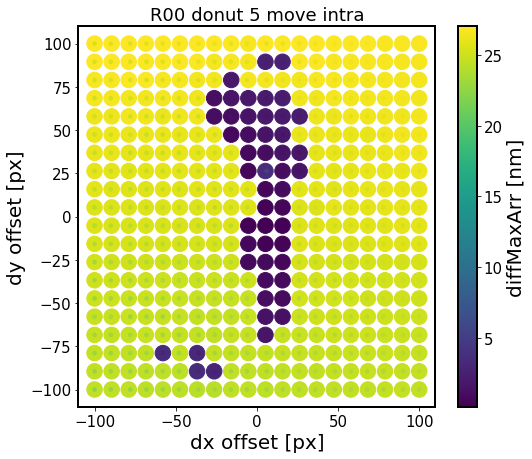

In [31]:
# read the data
sensor = 'R00'
defocal = 'intra'
i=5
fname = f'{sensor}_donut_{i}_{defocal}_offset_results_square_grid.npy'
results = np.load(fname, allow_pickle=True).item()

# convert to continuous arrays
diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPxArr.append(results[j]['dxPx'])
    dyPxArr.append(results[j]['dyPx'])
    diffMaxArr.append(results[j]['diffMax'])
    diffRmsArr.append(results[j]['diffRms'])

    

fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(np.array(dxPxArr), np.array(dyPxArr), c=diffMaxArr, s=240)
#ax.hexbin(dxPxArr,dyPxArr,C=diffRmsArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}')
plt.colorbar(sc, label = 'diffMaxArr [nm]')

That's very weird:  need to see the actual Zk values... 

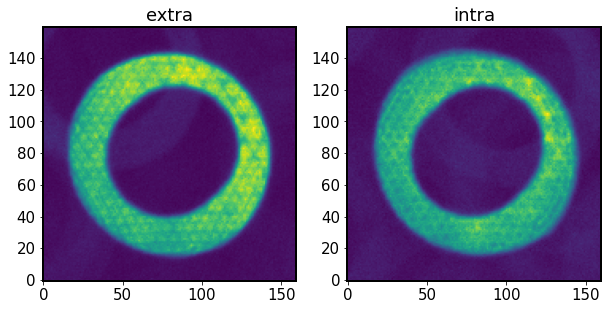

In [32]:
# read the baseline fit 
fname = f'{sensor}_donut_{i}_no_offset_zk.txt'
zk0 = np.loadtxt(fname,)

#plot the intra / extra donuts 
repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'

# iterate over all sensors
#for sensor in ['R00','R40','R44','R04']: 
    
# schoose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

donutExtra = donutStampsExtra[i]
donutIntra = donutStampsIntra[i]
fig,ax = plt.subplots(1,2,figsize=(10,7))
ax[0].set_title('extra')
ax[0].imshow(donutExtra.stamp_im.image.array, origin='lower')
ax[1].set_title('intra')
ax[1].imshow(donutIntra.stamp_im.image.array, origin='lower')

In [22]:
donutExtra.calcFieldXY()

(-1.23825, -1.1585555555555556)

In [23]:
donutIntra.calcFieldXY()

(-1.2392499999999997, -1.2712777777777775)

For R00:

- The weird part for donut 1  is that there's a hot pixel or sth messing the  image balance in the intra-focal stamp.

- For donuts 3, 4 one is much more vignetted than the other 

Plot in zk space the baseline and the example fit ...

In [21]:
results[j]['drPx']

141.4213562373095

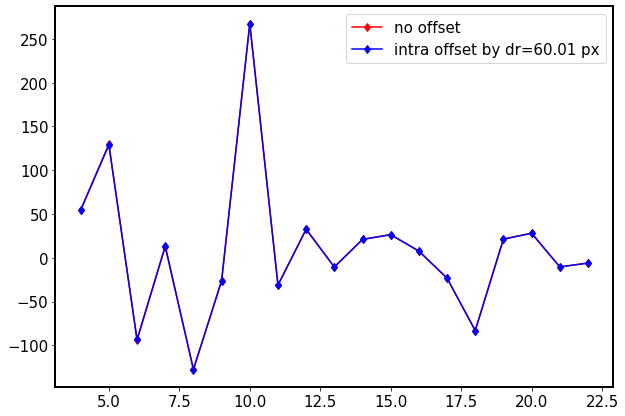

In [33]:
j = 175
fig,ax = plt.subplots(1,1,figsize=(10,7))
#ax.set_title(radialOffsetDegrees)
ax.plot(np.arange(4, 23), zk0 ,'-d', color = 'red',  label='no offset')
drPx = results[j]['drPx']
ax.plot(np.arange(4, 23), results[j]['zk'] ,'-d', color = 'blue',  label=f'{defocal} offset by dr={drPx:.2f} px')
ax.legend(fontsize=15)

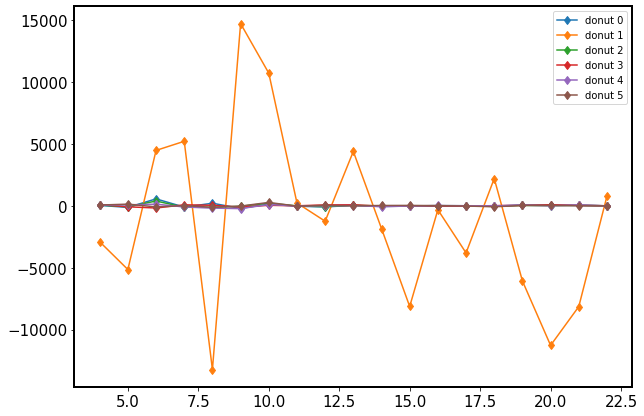

In [35]:
# plot all donuts in that simulation....
fig,ax = plt.subplots(1,1,figsize=(10,7))
#ax.set_title(radialOffsetDegrees)
for i in range(6):
    fname = f'{sensor}_donut_{i}_no_offset_zk.txt'
    zk0 = np.loadtxt(fname,)
    
    ax.plot(np.arange(4, 23), zk0 ,'-d', label=f'donut {i}' )
    #ax.plot(np.arange(4, 23), results[175]['zk'] ,'-d', color = 'blue', )
ax.legend()

ok, so even the baseline for donut 1 compared to the other ones looks wrong. What if we only plot the other ones?

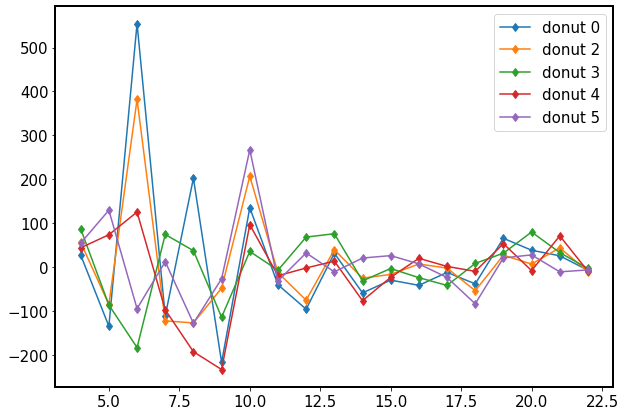

In [102]:
# plot all donuts in that simulation....
fig,ax = plt.subplots(1,1,figsize=(10,7))
#ax.set_title(radialOffsetDegrees)
for i in [0,2,3,4,5]:
    fname = f'{sensor}_donut_{i}_no_offset_zk.txt'
    zk0 = np.loadtxt(fname,)
    
    ax.plot(np.arange(4, 23), zk0 ,'-d', label=f'donut {i}' )
    #ax.plot(np.arange(4, 23), results[175]['zk'] ,'-d', color = 'blue', )
ax.legend()

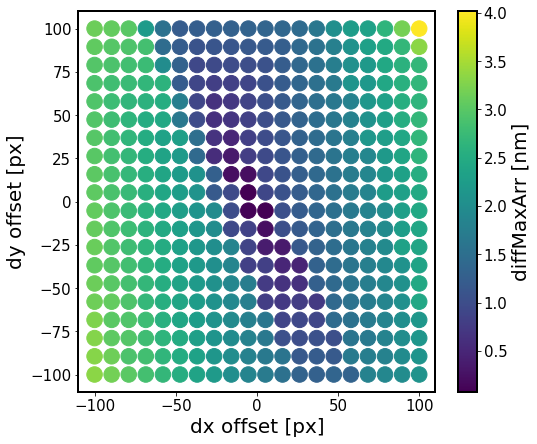

In [183]:
fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(np.array(dxPxArr), np.array(dyPxArr), c=diffMaxArr, s=240)
ax.hexbin(dxPxArr,dyPxArr,C=diffMaxArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
plt.colorbar(sc, label = 'diffMaxArr [nm]')

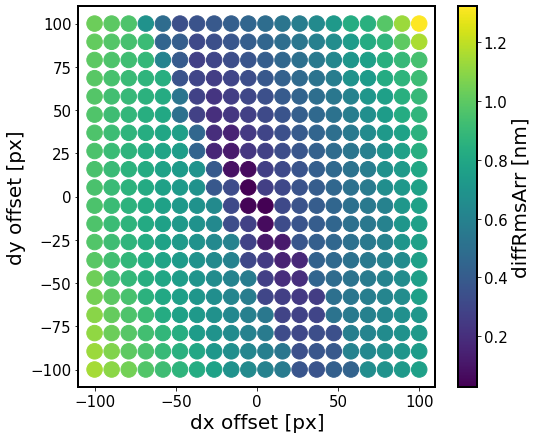

In [184]:
fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(np.array(dxPxArr), np.array(dyPxArr), c=diffRmsArr, s=240)
ax.hexbin(dxPxArr,dyPxArr,C=diffRmsArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
plt.colorbar(sc, label = 'diffRmsArr [nm]')

# Circle of diffRmsArr - how far can we be off? Depends on directionality and donut location...

Another experiment (instead of brute-force array) would be to calculate the diffRmsArr increasing the radius until a given threshold is met.

Step 1 : load the donuts, setup - the same 

In [67]:
# Load the stamps
repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'

# iterate over all sensors
#for sensor in ['R00','R40','R44','R04']: 
    
# schoose R00 or R44
sensor = 'R04'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)
# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()


configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# now instead of calling 
# wfEsti = WfEstimator(instDir, algoDir)
# I dig inside it 

# this is part of the init 
inst = Instrument(instDir)
algo = Algorithm(algoDir)

#imgIntra = CompensableImage()
#imgExtra = CompensableImage()

#opticalModel = ""
#sizeInPix = 0

# now get the camera type and defocal distance
# inside estimateZernikes()
# instName gets specified in the config,
# and does not get overridden for CWFS
# https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L134
instName='lsst'    
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

# now instead of calling 
# wfEsti.config( sizeInPix=self.donutStampSize, camType=camType,
#                opticalModel=self.opticalModel, defocalDisInMm=defocalDisInMm,
# )

# I update the parameters 
opticalModel = 'offAxis'
# Update the instrument name
#donutStampSize = 160 # px 
#sizeInPix = donutStampSize
sizeInPix = 160# int(sizeInPix)

inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

# choose the solver for the algorithm 
solver = 'exp' # by default 
debugLevel=0 # 1 to 3 
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)


In [324]:
len(donutStampsIntra)

for i in np.arange(1,6):
    print(donutStampsIntra[i].centroid_position)

(1335, 1158)
(3069, 864)
(1155, 705)
(376, 1387)
(3253, 1300)


In [322]:
donutStampsIntra[0].centroid_position

Point2D(3722, 1576)

## Running below for all other donuts for that sensor...

In [68]:



###
# now we'd normally loop over donut images 
###
i = 0 
for donutExtra, donutIntra in zip(donutStampsExtra, donutStampsIntra):
    #donutExtra = donutStampsExtra[i]
    #donutIntra = donutStampsIntra[i]

    fieldXYExtra = donutExtra.calcFieldXY()
    fieldXYIntra = donutIntra.calcFieldXY()

    camera = donutExtra.getCamera() # same camera for both donuts 
    detectorExtra = camera.get(donutExtra.detector_name)
    detectorIntra = camera.get(donutIntra.detector_name)


    # Rotate any sensors that are not lined up with the focal plane.
    # Mostly just for the corner wavefront sensors. The negative sign
    # creates the correct rotation based upon closed loop tests
    # with R04 and R40 corner sensors.
    eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
    eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

    # Now instead of running `wfEsti.setImg` method, do it by hand, since 
    # it inherits 'setImg' from 'CompensableImage' anyway...


    #NOTE: TS_WEP expects these images to be transposed
    # TODO: Look into this
    # wfEsti.setImg(
    #     fieldXYExtra,
    #     DefocalType.Extra,
    #     image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T,
    # )
    # wfEsti.setImg(
    #     fieldXYIntra,
    #     DefocalType.Intra,
    #     image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T,
    # )
    #for dx in -np.array(offsetDegreesList):


    #####################################
    # Step 2 : baseline fit (no offset)
    #####################################
    imgExtra.setImg(fieldXYExtra,
                    DefocalType.Extra,
                    image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

    imgIntra.setImg(fieldXYIntra,
                    DefocalType.Intra,
                    image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

    boundaryT = algo.getBoundaryThickness()

    # right after we set the image, the compensable image mask is empty - 
    # it is only calculated in algo
    # https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694
    maskScalingFactorLocal = 1
    imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
    imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)


    # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
    algo.reset()

    # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
    # simply calls algo:
    tol = 1e-3 # explicitly set the tolerance level ( this is default )
    algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
    zk_no_offset = algo.getZer4UpInNm()
    fname = f'{sensor}_donut_{i}_no_offset_zk.txt'
    np.savetxt(fname, zk_no_offset)
    print(f'\nSaved the baseline fit as {fname}')
    
    #####################################
    # Step 3 :  circle of diffRms , for `intra` and `extra` offsets....
    #####################################
    
    for defocal in ['intra','extra']: # or extra 
        print(f'Fitting {sensor} donut {i} shifting {defocal} centroid ')
        zk0 = zk_no_offset

        # starting boundary conditions 
        thetaRad = 0 # radians
        dthetaRad = 0.2 # radians ~ 11.45 deg 
        drPxStep = 10# pixels 

        diffRmsThresh = 1.0 # nm 

        results = {}

        j=0
        # iterate over a range of angles 
        for thetaRad in np.arange(0,2*np.pi, dthetaRad):

            # always start from 0 radius ... 
            drPx = 0 # px 
            diffRms = 0 # nm 

            # increase radius until threshold is reached 
            while diffRms < diffRmsThresh:

                dxPx = drPx*np.cos(thetaRad)
                dyPx = drPx*np.sin(thetaRad)

                dxDeg = (dxPx * pixelScale) / 3600.
                dyDeg = (dyPx * pixelScale) / 3600.

                results[j]={'dxPx':dxPx, 'dyPx':dyPx, 'dxDeg':dxDeg, 'dyDeg':dyDeg,
                           'drPx':drPx, }
                #print(j, drPx, thetaRad, diffRms)

                # do the fit 
                if defocal == 'extra':
                    fieldXYExtraUpd = (fieldXYExtra[0]+dxDeg, fieldXYExtra[1]+dyDeg)
                    fieldXYIntraUpd = fieldXYIntra

                elif defocal =='intra':
                    fieldXYExtraUpd = fieldXYExtra
                    fieldXYIntraUpd = (fieldXYIntra[0]+dxDeg, fieldXYIntra[1]+dyDeg)

                imgExtra.setImg(fieldXYExtraUpd,
                                DefocalType.Extra,
                                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

                imgIntra.setImg(fieldXYIntraUpd,
                                DefocalType.Intra,
                                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

                # calculate the mask 
                maskScalingFactorLocal = 1
                boundaryT = algo.getBoundaryThickness()
                imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
                imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)

                # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
                algo.reset()

                # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
                # simply calls algo:
                tol = 1e-3 # explicitly set the tolerance level ( this is default )
                algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
                zk = algo.getZer4UpInNm()
                results[j]['zk'] = zk


                # calculate diffMax, diffRms
                diffMax = np.max(np.abs(zk - zk0))
                diffRms = np.sqrt(np.sum(np.abs(zk - zk0) ** 2) / len(zk))

                # store the results 
                results[j]['diffMax'] = diffMax
                results[j]['diffRms'] = diffRms
                results[j]['zk'] = zk
                results[j]['imgExtraFieldXY'] = imgExtra.getFieldXY()
                results[j]['imgIntraFieldXY'] = imgIntra.getFieldXY()

                # increase the radius
                drPx += drPxStep 

                # increase the counter 
                j += 1
            print(j-1, drPx, thetaRad, diffRms) 
            print('Threshold reached at radius ', drPx)  


        # store the results  for  shifting the extra-focal donut or 
        # shifting the intra-focal donut 
        fname = f'{sensor}_donut_{i}_{defocal}_offset_results_circle.npy'
        print(f"saved {fname}")
        np.save(fname, results)
        
    # increase donut counter 
    i += 1 


Saved the baseline fit as R04_donut_0_no_offset_zk.txt
Fitting R04 donut 0 shifting intra centroid 
6 70 0.0 1.0795350190290467
Threshold reached at radius  70
14 80 0.2 1.0257585307238024
Threshold reached at radius  80
23 90 0.4 1.0766025209083
Threshold reached at radius  90
36 130 0.6000000000000001 1.0934668496743456
Threshold reached at radius  130
55 190 0.8 1.0508973595318072
Threshold reached at radius  190
69 140 1.0 1.0254905072029583
Threshold reached at radius  140
77 80 1.2000000000000002 1.0556585627666732
Threshold reached at radius  80
83 60 1.4000000000000001 1.030519296476457
Threshold reached at radius  60
88 50 1.6 1.019888964083837
Threshold reached at radius  50
93 50 1.8 1.463371793699157
Threshold reached at radius  50
98 50 2.0 1.4890126748877766
Threshold reached at radius  50
103 50 2.2 1.6288197432272318
Threshold reached at radius  50
107 40 2.4000000000000004 1.2009791397277565
Threshold reached at radius  40
112 50 2.6 1.6284274959034348
Threshold reach

448 270 3.8000000000000003 1.0316930257662476
Threshold reached at radius  270
474 260 4.0 1.0205680802461534
Threshold reached at radius  260
496 220 4.2 1.0413954813864956
Threshold reached at radius  220
516 200 4.4 1.044669763335778
Threshold reached at radius  200
534 180 4.6000000000000005 1.0120071780076325
Threshold reached at radius  180
551 170 4.800000000000001 1.009744124027167
Threshold reached at radius  170
568 170 5.0 1.0436517087146837
Threshold reached at radius  170
585 170 5.2 1.057641412489525
Threshold reached at radius  170
602 170 5.4 1.0489983842160546
Threshold reached at radius  170
619 170 5.6000000000000005 1.0169447505219704
Threshold reached at radius  170
637 180 5.800000000000001 1.0208670687536103
Threshold reached at radius  180
657 200 6.0 1.0503707452058648
Threshold reached at radius  200
679 220 6.2 1.042750120478677
Threshold reached at radius  220
saved R04_donut_1_extra_offset_results_circle.npy

Saved the baseline fit as R04_donut_2_no_offset_

KeyboardInterrupt: 

In [304]:
#zk0 = np.loadtxt(f'{sensor}_donut_{i}_no_offset_zk.txt')

In [315]:
i

6

0 0 0.0 0
1 10 0.0 0.0
2 20 0.0 0.08183691257185563
3 30 0.0 0.3276375677119176
4 40 0.0 0.3914870440844022
5 50 0.0 0.5451850638084487
6 60 0.0 0.6734317772071625
7 70 0.0 0.7498864045134719
8 80 0.0 0.8177201816017313
Threshold reached at radius  90
9 0 0.2 0
10 10 0.2 0.0
11 20 0.2 0.27107476743130654
12 30 0.2 0.3287738098961284
13 40 0.2 0.3995022132540316
14 50 0.2 0.626277462167345
15 60 0.2 0.7104576477870467
16 70 0.2 0.785242091894803
Threshold reached at radius  80
17 0 0.4 0
18 10 0.4 0.0
19 20 0.4 0.26745663948459547
20 30 0.4 0.32751748786318396
21 40 0.4 0.5012472492773775
22 50 0.4 0.6458331321667832
23 60 0.4 0.7249392282108169
Threshold reached at radius  70
24 0 0.6000000000000001 0
25 10 0.6000000000000001 0.0
26 20 0.6000000000000001 0.2624999379137913
27 30 0.6000000000000001 0.3227813152228557
28 40 0.6000000000000001 0.5624881355791158
29 50 0.6000000000000001 0.6549506295468438
30 60 0.6000000000000001 0.7375055449671165
Threshold reached at radius  70
31 0 0.8

Threshold reached at radius  80
238 0 4.6000000000000005 0
239 10 4.6000000000000005 0.0
240 20 4.6000000000000005 0.09270700008339072
241 30 4.6000000000000005 0.33108692937572276
242 40 4.6000000000000005 0.549964528531168
243 50 4.6000000000000005 0.6186835599551893
244 60 4.6000000000000005 0.6817801938589966
245 70 4.6000000000000005 0.7696064781343593
246 80 4.6000000000000005 0.9572618768306135
247 90 4.6000000000000005 0.9930739417618585
Threshold reached at radius  100
248 0 4.800000000000001 0
249 10 4.800000000000001 0.0
250 20 4.800000000000001 0.0827536927829045
251 30 4.800000000000001 0.1517664697850972
252 40 4.800000000000001 0.46894669606040557
253 50 4.800000000000001 0.5637429498467584
254 60 4.800000000000001 0.6187595157203356
255 70 4.800000000000001 0.6728957969542662
256 80 4.800000000000001 0.7362950836226307
257 90 4.800000000000001 0.8814030542388626
258 100 4.800000000000001 0.923361301651418
Threshold reached at radius  110
259 0 5.0 0
260 10 5.0 0.0
261 2

86 100 1.2000000000000002 0.699609816926286
87 110 1.2000000000000002 0.7375120064845303
88 120 1.2000000000000002 0.7772730022195508
89 130 1.2000000000000002 0.8186151183366412
90 140 1.2000000000000002 0.8536805506937771
91 150 1.2000000000000002 0.8972563518846816
Threshold reached at radius  160
92 0 1.4000000000000001 0
93 10 1.4000000000000001 0.0
94 20 1.4000000000000001 0.2064191235709166
95 30 1.4000000000000001 0.5072969715614852
96 40 1.4000000000000001 0.5148222577638624
97 50 1.4000000000000001 0.5270744678495098
98 60 1.4000000000000001 0.5436531737964406
99 70 1.4000000000000001 0.5640967934170312
100 80 1.4000000000000001 0.5880864066303844
101 90 1.4000000000000001 0.6152256225983774
102 100 1.4000000000000001 0.6451045205126418
103 110 1.4000000000000001 0.6773600873390204
104 120 1.4000000000000001 0.7116891029027574
105 130 1.4000000000000001 0.7478052205951673
106 140 1.4000000000000001 0.7855089025383836
107 150 1.4000000000000001 0.8245184046852134
108 160 1.400

317 170 3.4000000000000004 0.7855698672532152
318 180 3.4000000000000004 0.834392030580212
319 190 3.4000000000000004 0.8832299362731998
320 200 3.4000000000000004 0.9320940864257761
Threshold reached at radius  210
321 0 3.6 0
322 10 3.6 0.0
323 20 3.6 0.05542504493055281
324 30 3.6 0.11001248767260174
325 40 3.6 0.1625163081155622
326 50 3.6 0.21089217200039573
327 60 3.6 0.26034944745579336
328 70 3.6 0.3103072100700914
329 80 3.6 0.36063625440147906
330 90 3.6 0.411161976224206
331 100 3.6 0.4618096773442683
332 110 3.6 0.5125291778409923
333 120 3.6 0.5633633417930534
334 130 3.6 0.6143220154546045
335 140 3.6 0.6654130482100619
336 150 3.6 0.7165265074707142
337 160 3.6 0.767677194115173
338 170 3.6 0.81882084435486
339 180 3.6 0.8699529456516117
340 190 3.6 0.9210546304278056
341 200 3.6 0.9721865623096636
Threshold reached at radius  210
342 0 3.8000000000000003 0
343 10 3.8000000000000003 0.0
344 20 3.8000000000000003 0.05680937601789952
345 30 3.8000000000000003 0.11243103191

544 60 5.800000000000001 0.6437119898400856
545 70 5.800000000000001 0.6739188333709988
546 80 5.800000000000001 0.7047861704308285
547 90 5.800000000000001 0.7362435627492963
548 100 5.800000000000001 0.7682130299976013
549 110 5.800000000000001 0.8006288092634886
550 120 5.800000000000001 0.8334482841412001
551 130 5.800000000000001 0.8666469360284249
552 140 5.800000000000001 0.9002379239284245
553 150 5.800000000000001 0.9375444596488591
554 160 5.800000000000001 0.9716711888068799
Threshold reached at radius  170
555 0 6.0 0
556 10 6.0 0.0
557 20 6.0 0.2310403420672102
558 30 6.0 0.5595967284189463
559 40 6.0 0.5883446812441586
560 50 6.0 0.6185001514364252
561 60 6.0 0.649896890789473
562 70 6.0 0.6823150271855482
563 80 6.0 0.7156036699231962
564 90 6.0 0.7496623652167551
565 100 6.0 0.7844309765295931
566 110 6.0 0.8198234985206335
567 120 6.0 0.8557388235216129
568 130 6.0 0.8937730930847643
569 140 6.0 0.9305048038979796
570 150 6.0 0.9676921411912152
Threshold reached at rad

In [308]:
results[0]

{'dxPx': 0.0,
 'dyPx': 0.0,
 'dxDeg': 0.0,
 'dyDeg': 0.0,
 'drPx': 0,
 'zk': array([  29.74953058, -193.83380742,  -58.79946359,  -14.55143455,
         160.55471567,   57.37004292, -158.07109421,  -29.41005834,
          23.75288335,   44.71491596,   65.51626547,  -15.75398777,
         -25.33344173,   17.26455109,   52.45140392,   14.79357358,
           3.11268118,  -17.38209158,   -6.68856922]),
 'diffMax': 0.0,
 'diffRms': 0.0,
 'imgExtraFieldXY': (1.2411388888888888, 1.1275),
 'imgIntraFieldXY': (1.17775, 1.2603888888888888)}

## Development code

Plot the results ... 

In [33]:
sensor = 'R00'
i = 0
defocal = 'extra'
fname = f'{sensor}_donut_{i}_{defocal}_offset_results_circle.npy'
results = np.load(fname, allow_pickle=True).item()
    

In [34]:
diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPx = results[j]['dxPx']
    dyPx = results[j]['dyPx'] 
    
    dxPxArr.append(dxPx)
    dyPxArr.append(dyPx)

    # calculate max difference and rms difference 
    # just like in test_multImgs.py for ts_wep 
    diffMax = results[j]['diffMax']
    diffRms = results[j]['diffRms']
    diffMaxArr.append(diffMax)
    diffRmsArr.append(diffRms)
    
    

(array([66., 57., 53., 54., 47., 54., 45., 49., 47., 25.]),
 array([0.        , 0.11337415, 0.22674829, 0.34012244, 0.45349659,
        0.56687073, 0.68024488, 0.79361903, 0.90699317, 1.02036732,
        1.13374147]),
 <BarContainer object of 10 artists>)

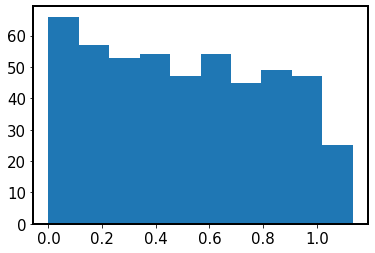

In [54]:
plt.hist(diffRmsArr)

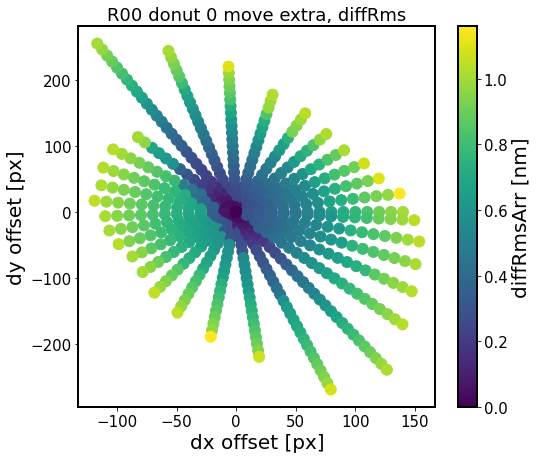

In [35]:
fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr, s=120)
#ax.scatter(dxPxArr,dyPxArr,c=diffRmsArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
plt.colorbar(sc, label = 'diffRmsArr [nm]')

In [187]:
defocal

'extra'

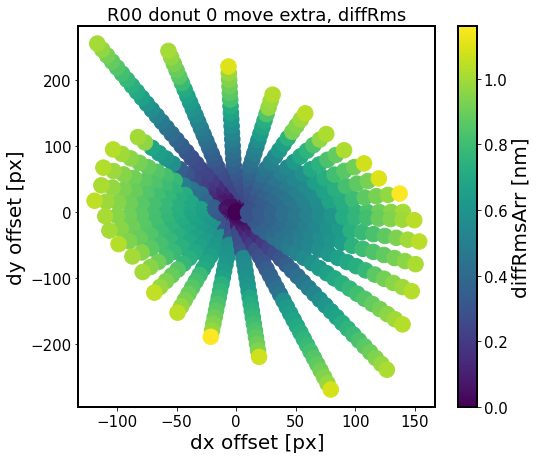

In [36]:
fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr, s=240)
#ax.scatter(dxPxArr,dyPxArr,c=diffRmsArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
plt.colorbar(sc, label = 'diffRmsArr [nm]')

Plot just the max value where the threshold of 1 nm has been reached... 

In [130]:

jrange = list(results.keys())
dxPxLastArr = []
dyPxLastArr = []
diffRmsLastArr = []
for j in jrange[1:]:
    #print(results[j]['drPx'])
    if results[j]['drPx'] == 0:
        #print(results[j-1]['dxPx'], results[j-1]['dyPx'], results[j-1]['diffRms'])
        dxPxLastArr.append(results[j-1]['dxPx'])
        dyPxLastArr.append(results[j-1]['dyPx'])
        diffRmsLastArr.append(results[j-1]['diffRms'])

In [134]:
results[0]

{'dxPx': 0.0,
 'dyPx': 0.0,
 'dxDeg': 0.0,
 'dyDeg': 0.0,
 'drPx': 0,
 'zk': array([  27.77139107, -134.18814102,  554.53522107, -110.63563282,
         202.63161655, -216.54001759,  135.40826742,  -39.80471225,
         -95.32633117,   31.95487532,  -58.33199173,  -29.22564598,
         -41.18162508,  -11.75681397,  -37.77502878,   65.918882  ,
          38.69327601,   26.08176439,   -6.85957416]),
 'diffMax': 0.0,
 'diffRms': 0.0,
 'imgExtraFieldXY': (-1.2765277777777775, -1.102888888888889),
 'imgIntraFieldXY': (-1.096638888888889, -1.222888888888889)}

In [94]:
a = np.arange(5)
b = np.roll(a,1)

In [99]:
np.resize(a,10)

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

In [112]:
np.shape(imgIntra.getImg())


(160, 160)

Text(0.5, 1.0, 'R00 donut 0 move extra, diffRms')

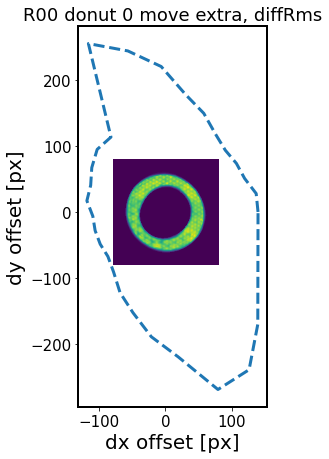

In [133]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
#N = 100
#sc = ax.scatter(dxPxLastArr, dyPxLastArr, c=diffRmsLastArr, s=240)
dxNew = np.resize(dxPxLastArr,len(dxPxLastArr)+1)
dyNew = np.resize(dyPxLastArr,len(dyPxLastArr)+1)

# https://moonbooks.org/Articles/How-to-change-imshow-axis-values-labels-in-matplotlib-/
half = np.shape(imgExtra.getImg())[0]/2.
x_min = -half
x_max = half
y_min = x_min
y_max = x_max
extent = [x_min , x_max, y_min , y_max]
ax.imshow(imgExtra.getImg(), origin='lower',extent = extent)
ax.plot(dxNew,dyNew,ls='--',lw=3)
N=0

#ax.scatter(dxPxLastArr[N], dyPxLastArr[N])
#ax.scatter(dxPxArr,dyPxArr,c=diffRmsLastArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
#plt.colorbar(sc, ax=ax, label = 'diffRmsArr [nm]')

In [223]:
dxNew

array([ 140.        ,  137.2093209 ,  119.73792922,  107.29362994,
         90.57187222,   75.64232282,   57.97724072,   30.59408572,
         -6.42389491,  -56.80052367, -116.52111423,  -82.39015642,
       -103.23512018, -111.39553794, -113.06668088, -118.79909959,
       -109.81242534, -106.34780118,  -98.6434258 ,  -87.00644831,
        -78.4372345 ,  -68.63651499,  -49.1732592 ,  -21.30898012,
         19.24977636,   79.42541193,  126.49950125,  139.63243271,
        140.        ])

Text(0.5, 1.0, 'R00 donut 0 move intra, diffRms')

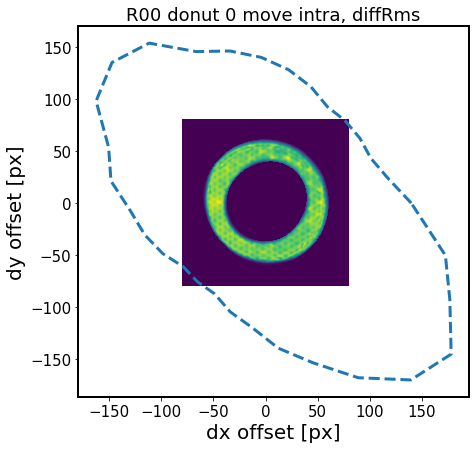

In [114]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
#N = 100
#sc = ax.scatter(dxPxLastArr, dyPxLastArr, c=diffRmsLastArr, s=240)
dxNew = np.resize(dxPxLastArr,len(dxPxLastArr)+1)
dyNew = np.resize(dyPxLastArr,len(dyPxLastArr)+1)

# https://moonbooks.org/Articles/How-to-change-imshow-axis-values-labels-in-matplotlib-/
half = np.shape(imgIntra.getImg())[0]/2.
x_min = -half
x_max = half
y_min = x_min
y_max = x_max
extent = [x_min , x_max, y_min , y_max]
ax.imshow(imgIntra.getImg(), origin='lower',extent = extent)
ax.plot(dxNew,dyNew,ls='--',lw=3)
N=0

#ax.scatter(dxPxLastArr[N], dyPxLastArr[N])
#ax.scatter(dxPxArr,dyPxArr,c=diffRmsLastArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
#plt.colorbar(sc, ax=ax, label = 'diffRmsArr [nm]')

Can make those plots in focal plane coordinates since I saved at each step the outcome of `imgExtraFieldXY`, `imgIntraFieldXY`...
Or could try doing what Josh did in the coordinate notebooks, but then I'd have to convert from the donut coord to focal plane coord...

In [135]:
camera = donutIntra.getCamera()

In [149]:
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

Doc is https://pipelines.lsst.io/modules/lsst.afw.cameraGeom/cameraGeom.html#camera-coordinate-systems
    
    FOCAL_PLANE Position on a 2-d planar approximation to the focal plane (x,y mm). The origin and orientation may be defined by the camera team, but we strongly recommend that the origin be on the optical axis and (if using CCD detectors) that the X axis be aligned along CCD rows. Note: location and orientation of detectors are defined in a 3-d version of FOCAL_PLANE coordinates (the z axis is also relevant).

    FIELD_ANGLE  Angle of a principal ray relative to the optical axis (x,y radians). The orientation of the x,y axes is the same as FOCAL_PLANE.
    
    PIXELS Nominal position on the entry surface of a given detector (x, y unbinned pixels). For CCD detectors the x axis must be along rows (the direction of the serial register). This is required for our interpolation algorithm to interpolate across bad columns.

    ACTUAL_PIXELS Like PIXELS, but takes into account pixel-level distortions (deviations from the nominal model of uniformly spaced rectangular pixels).

    TAN_PIXELS Is a variant of PIXELS with estimated optical distortion removed. TAN_PIXELS is an affine transformation from FIELD_ANGLE coordinates, where PIXELS and TAN_PIXELS match at the center of the pupil frame.

In [142]:
detector = camera.get(donutIntra.detector_name)

In [184]:
detector.getName()

'R00_SW1'

In [165]:
transform = detector.getTransform(PIXELS, FIELD_ANGLE) # to position in focal plane in radians 

In [166]:
zero = transform.applyForward(Point2D(0, 0))
xhat = transform.applyForward(Point2D(1000, 0))
yhat = transform.applyForward(Point2D(0, 1000))

In [168]:
np.rad2deg(zero[0])

-1.3034166666666664

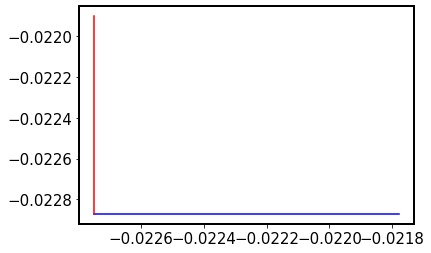

In [183]:
plt.plot([zero.x,xhat.x ], [zero.y, xhat.y] , color='blue',)
plt.plot([zero.x, yhat.x], [zero.y, yhat.y], color='red')
    
    

Convert the pixel offset coordinates to focal coordinates, to get the distance from the focal plane ... 

First, convert the pixel offset via donut centroid location to detector pixel coordinates

In [188]:
defocal 

'extra'

In [191]:
centroid = donutExtra.centroid_position

Point2D(3589, 590)

In [192]:
centroidFocal = transform.applyForward(centroid)

#dxPxArr

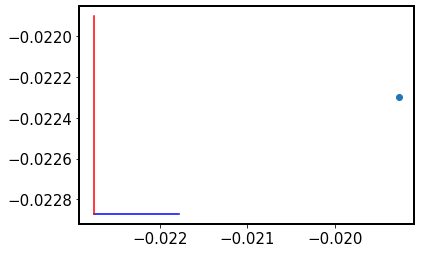

In [194]:
plt.plot([zero.x,xhat.x ], [zero.y, xhat.y] , color='blue',)
plt.plot([zero.x, yhat.x], [zero.y, yhat.y], color='red')
plt.scatter(centroidFocal.x, centroidFocal.y)

In [197]:
eulerZExtra = -detector.getOrientation().getYaw().asDegrees()
eulerZExtra

-360.0

In [ ]:
transform.getMapping().applyForward()

In [240]:
#ys = np.array(dxPxArr)+centroid.y # treat as y
#xs = np.array(dyPxArr)+centroid.x # treat as x 

ys = dxNew+centroid.y
xs = dyNew+centroid.x

fps = [Point2D(fpx_, fpy_) for fpx_, fpy_ in zip(xs, ys)]

pixels = transform.applyForward(fps)

fpx = []
fpy = []
for pixel in pixels:
    fpx.append(pixel.x)
    fpy.append(pixel.y)

In [235]:
This makes sense: in the radial direction vignetting increases most quickly. 

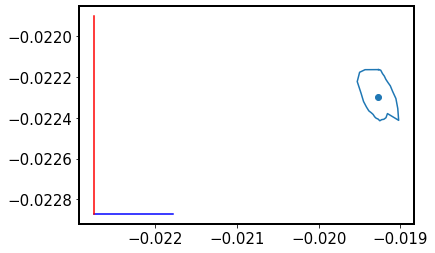

In [252]:
plt.plot([zero.x,xhat.x ], [zero.y, xhat.y] , color='blue',)
plt.plot([zero.x, yhat.x], [zero.y, yhat.y], color='red')
plt.plot(fpx,fpy)
#plt.scatter(fpx,fpy,c=diffRmsArr, s=140)
plt.scatter(centroidFocal.x, centroidFocal.y)
#plt.arrow(zero.x, zero.y, xhat.x-zero.x, yhat.y-zero.y, width=1e-4)

# Plot the diffRms zone in field angle coords

* Read the donut postage stamp (intra, extra)
* Read the results of calculation for a given donut (moving intra, moving extra). 
* Convert the results from dic to array in donut coords
* Read out the final radius  so that we have an outline 
* Convert to detector coords
* Convert to field angle coords

* Plot the donut location and the outline of how far can we  move that donut location (fieldXY) passed to the algorithm before the diffRms calculated against the baseline (no offset) is greater than 1 nm (i.e. still barely detectable)





In [69]:
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

# Load the stamps
repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'

def extract_max_radius(results):
    dxPxLastArr = []
    dyPxLastArr = []
    diffRmsLastArr = []
    jrange = list(results.keys())
    for j in jrange[1:]:
        #print(results[j]['drPx'])
        if results[j]['drPx'] == 0:
            #print(results[j-1]['dxPx'], results[j-1]['dyPx'], results[j-1]['diffRms'])
            dxPxLastArr.append(results[j-1]['dxPx'])
            dyPxLastArr.append(results[j-1]['dyPx'])
            diffRmsLastArr.append(results[j-1]['diffRms'])
    return  dxPxLastArr, dyPxLastArr, diffRmsLastArr




# iterate over all sensors
summary = {}

#for sensor in ['R00','R40','R44','R04']: 
for sensor in ['R04']:    
# choose R00 or R44
#sensor = 'R00'
    

    #print(f'Fitting {sensor}')
    donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW0",
                                          dataset_type = 'donutStampsExtra', 
                                          collection=collection)

    donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW1",
                                          dataset_type = 'donutStampsIntra', 
                                          collection=collection)




    # iterate over all donuts 
    for i in range(3):#i = 0 
    #i = 0
    #for donutIntra, donutExtra in zip(donutStampsIntra, donutStampsExtra):
        
        donutIntra = donutStampsIntra[i]
        donutExtra = donutStampsExtra[i]

        # need to zip because there's different transform for intra 
        # and extra-focal detector 
        for defocal, donut in zip(['extra','intra'], [donutExtra, donutIntra]):
            key = f'{sensor}_{i}_{defocal}'
            summary[key] = {}

            fname = f'{sensor}_donut_{i}_{defocal}_offset_results_circle.npy'
            results = np.load(fname, allow_pickle=True).item()

            # extract the zone reached when diffRms >= 1 nm 
            dxPxLastArr, dyPxLastArr, diffRmsLastArr = extract_max_radius(results)

            # resize to plot an outline by rolling +1 
            dxNew = np.resize(dxPxLastArr,len(dxPxLastArr)+1)
            dyNew = np.resize(dyPxLastArr,len(dyPxLastArr)+1)


            summary[key]['dxOutline'] = dxNew
            summary[key]['dyOutline'] = dyNew


            # transform from donut coords to field angle coords 

            # first, get the camera and detector 

            camera = donut.getCamera()
            detector = camera.get(donut.detector_name)

            # to position in focal plane in radians
            transform = detector.getTransform(PIXELS, FIELD_ANGLE) 
            zero = transform.applyForward(Point2D(0, 0))
            xhat = transform.applyForward(Point2D(4000, 0))
            yhat = transform.applyForward(Point2D(0, 2000))


            centroid = donut.centroid_position
            centroidFieldAngle = transform.applyForward(centroid)

            # transform outline from donut px coords (via centroid) 
            # to detector px coords (via transform) to field coords
            ys = dxNew+centroid.y # treat x as y due to transpose done by ts_wep
            xs = dyNew+centroid.x

            fps = [Point2D(fpx_, fpy_) for fpx_, fpy_ in zip(xs, ys)]

            pixels = transform.applyForward(fps)

            # this is now in field angle coords, i.e. radians 
            fpx = [pixel.x for pixel in pixels]
            fpy = [pixel.y for pixel in pixels]


            # finally get detector center in field angle coord
            center = detector.getCenter(FIELD_ANGLE)

            summary[key]['dxOutlineRad'] = fpx
            summary[key]['dyOutlineRad'] = fpy
            summary[key]['centroidDetector'] = centroid
            summary[key]['centroidFieldAngle'] = centroidFieldAngle
            summary[key]['zeroFieldAngle'] = zero
            summary[key]['xHatFieldAngle'] = xhat
            summary[key]['yHatFieldAngle'] = yhat
            summary[key]['detectorCenterFieldAngle'] = center
            summary[key]['detectorName'] = detector.getName()
        # increase donut count 
        #i += 1 

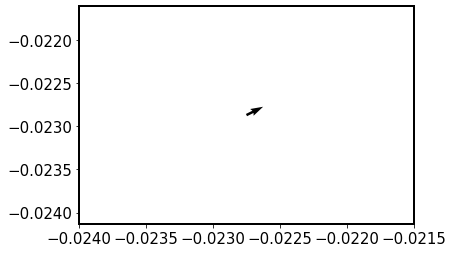

In [273]:
plt.quiver(zero.x, zero.y, xhat.x-zero.x, yhat.y-zero.y
          )

In [46]:
''.join([detector,defocal])


'R00intra'

R04_0_extra 583.0 945.0
R04_0_intra 2288.0 303.0
R04_1_extra 3098.0 996.0
R04_1_intra 911.0 1630.0
R04_2_extra 3407.0 398.0
R04_2_intra 697.0 790.0


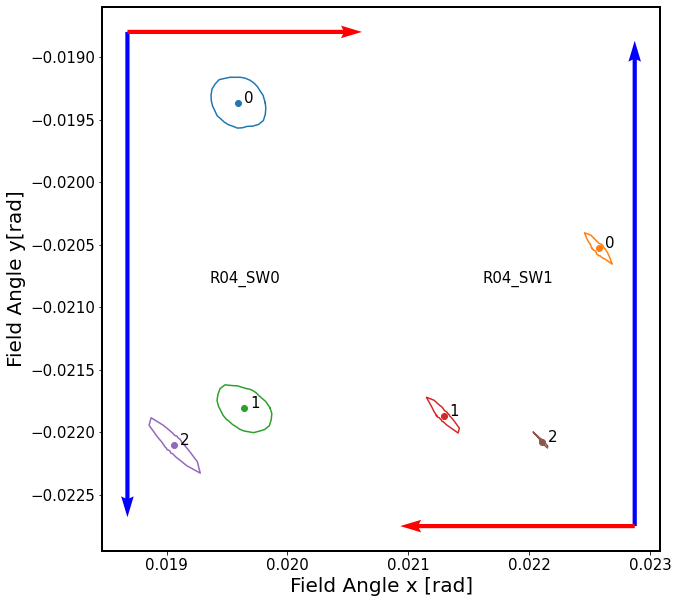

In [70]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

detectors_plotted = []
for key in summary.keys():
    xhat = summary[key]['xHatFieldAngle']
    yhat = summary[key]['yHatFieldAngle']
    zero = summary[key]['zeroFieldAngle']
    fpx = summary[key]['dxOutlineRad']
    fpy = summary[key]['dyOutlineRad']
    centroidFocal = summary[key]['centroidFieldAngle']
    centroid = summary[key]['centroidDetector'] 
    print(key, centroid.x, centroid.y)
    # plot lines 
    #plt.plot([zero.x,xhat.x ], [zero.y, xhat.y] , color='blue',)
    #plt.plot([zero.x, yhat.x], [zero.y, yhat.y], color='red')
    ax.plot(fpx,fpy)
    #plt.scatter(fpx,fpy,c=diffRmsArr, s=140)
    ax.scatter(centroidFocal.x, centroidFocal.y)
    
    
    detector, donut, defocal = key.split('_')

    # plot donut name 
    ax.text(centroidFocal.x+5*1e-5, centroidFocal.y, donut, fontsize=15)
    
    
    # plot the detector outline and names just once 
    det_defocal = ''.join([detector,defocal])
    if det_defocal not in detectors_plotted:
        #plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1)
        ax.quiver(zero.x, zero.y, xhat.x-zero.x, xhat.y-zero.y, color='blue',lw=2, 
                   scale_units='xy', angles='xy', scale=1)
        ax.quiver(zero.x, zero.y, yhat.x-zero.x, yhat.y-zero.y, color='red', lw=2,
                  scale_units='xy', angles='xy', scale=1)

        center = summary[key]['detectorCenterFieldAngle']
        txt = f"{summary[key]['detectorName']}"
        ax.text(center.x, center.y, txt, 
                 fontsize=15, horizontalalignment='center', 
                 verticalalignment='center',)# rotation=rotation)

        detectors_plotted.append(det_defocal)
ax.set_xlabel('Field Angle x [rad]')
ax.set_ylabel('Field Angle y[rad]')
plt.savefig(f'{sensor}_diffRms_circle.png', bbox_inches='tight')

In [291]:
center.x

-214.26000000000002

Instead of moving the mask, it seems it just calculates it for a different location... Is it even possible to move the mask??

In [115]:

# Ok so this shows that in this case, before fitting the extra-focal donut gets a mask that's 0.1 degrees of in dx,dy


In [123]:
#plot_comp_img(imgIntra,imgExtra,i, title='after')

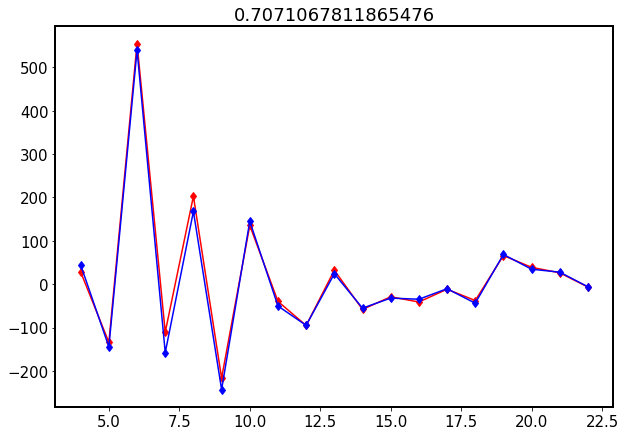

In [116]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.set_title(radialOffsetDegrees)
ax.plot(np.arange(4, 23), zk_no_offset ,'-d', color = 'red', )
ax.plot(np.arange(4, 23), zk_offset ,'-d', color = 'blue', )

Quantify the difference as `diffmax` and `diffrms` , just like in `test_multImgs` for `ts_wep` :
    
    

In [118]:
wfErrAns = zk_no_offset
wfErr = zk_offset

diffMax = np.max(np.abs(wfErr - wfErrAns))
diffRms = np.sqrt(np.sum(np.abs(wfErr - wfErrAns) ** 2) / len(wfErr))

In [119]:
print('diffMax is ', diffMax)
print('diffRms ', diffRms)

diffMax is  47.21801455735843
diffRms  16.460008243939


So if the mask is calculated for any region within ~half of the donut postage stamp size, it will work just fine 

In [35]:
# extract the separation from the resuts
dxs = []
dys = []
for j in results.keys():
    dxs.append(results[j]['dx'])
    dys.append(results[j]['dy'])

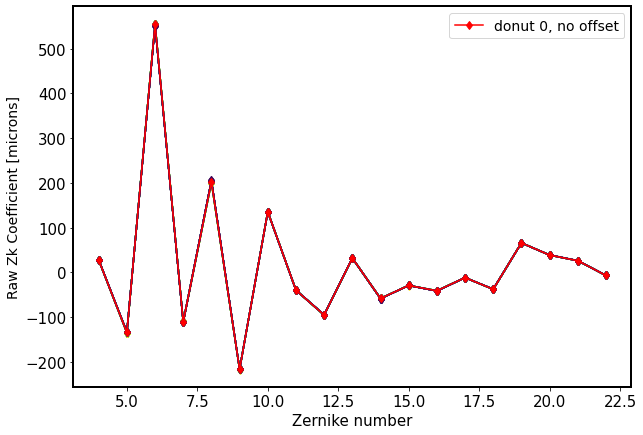

In [36]:
fig,ax = plt.subplots(1,1,figsize=(10,7))

minval = min(dxs)
maxval = max(dxs)
bounds = np.linspace(minval, maxval) 
cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')


normCol = mpl.colors.Normalize(vmin=minval, vmax=maxval)

for j in results.keys():
    zks = results[j]['zk']
    dx = results[j]['dx']
    ax.plot(np.arange(4, 23), zks ,'-d', color = cmap(normCol(dx)), )#label=f"{key}")
    
# plot the original zk estimate for the first donut pair 
ax.plot(np.arange(4, 23), results[0]['zk'],'-d', c='r', label=f"donut {i}, no offset") 

ax.set_xlabel("Zernike number", size=15)
ax.set_ylabel('Raw Zk Coefficient [microns]', size=14)
ax.legend(loc='upper right', fontsize=14)


#([xmin,ymin,dx,dy])
# cax = fig.add_axes([0.97,0.1,0.02,0.8])
# cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=cax, orientation='vertical',
#                    format='%.d'
#                    )
# cbar.ax.tick_params(labelsize=15,)
# cbar.set_label(label=  "centroid offset (+x,+y) [px]", size=18)
plt.show()
#ax.set_title('centroid dx=dy offset, 0 to 50 px')


Need to move probably both masks by a certain distance, most likely in the pixel space - how does the pixel space correspond to degrees offset? 



dimOfDonut 160
apertureDiameter 8.36
focalLength  10.312
offset 0.0015
rMask 0.0006080294802172227
pixelSize 1e-05


array([[0.        , 0.        , 1.        , 1.        ],
       [0.        , 0.        , 0.61      , 0.        ],
       [0.2228228 , 0.19396313, 1.22326442, 1.        ],
       [0.08903842, 0.0775063 , 0.56420812, 0.        ]])

In [104]:
model

'offAxis'